# Introduction

In this notebook, we will simulate **momentum-based trading strategies**. We will use historical stock price data to implement these strategies and evaluate their performance over a specified period.

**Strategies covered:**
1. **Price Momentum** - Moving Average Crossover
2. **RSI Momentum** - Relative Strength Index
3. **MACD Momentum** - Moving Average Convergence Divergence
4. **ROC Momentum** - Rate of Change
5. **Volume-Weighted Momentum** - Price + Volume confirmation
6. **OBV/VPT Momentum** - On-Balance Volume / Volume Price Trend
7. **MFI Momentum** - Money Flow Index
8. **Triple Momentum** - Multi-timeframe momentum
9. **Accelerating Momentum** - Momentum of momentum

Pipeline for an algorithmic trading strategy includes the following steps:
1. **Data Collection**: Gather historical stock price data (we use crawler)
2. **Data Preprocessing**: Clean and preprocess the data 
3. **Strategy Implementation**: Define the rules for momentum strategies
4. **Parameter Optimization**: Find optimal parameters using Optuna
5. **Backtesting**: Simulate the strategies over historical data
6. **Performance Evaluation**: Analyze results using various metrics

---

# Set up 

## Library & Modules

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10


# Import modules
import sys
import os

# Add parent directory to path for imports
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Change working directory to parent so relative paths work
os.chdir(parent_dir)

# Data loading and utilities
from utils import (
    load_all_historical, 
    check_data_quality, print_data_quality_report,
    plot_strategy_analysis, print_backtest_results, plot_comparison_charts,
)

# Momentum strategies
from strategies import (
    PriceMomentum, RSIMomentum, MACDMomentum, ROCMomentum,
    VolumeWeightedMomentum, OBVMomentum,
    VPTMomentum, MFIMomentum, TripleMomentum, AcceleratingMomentum,
    MomentumPortfolio, backtest_strategy, compare_strategies
)

print("All modules imported successfully!")

All modules imported successfully!


## Visualization function

In [ ]:
def plot_strategy_analysis(df, result_df, backtest_result, strategy_name, indicator_col=None, indicator_name=None):
    """
    Common function to visualize strategy analysis.
    
    Args:
        df: Original dataframe with price data
        result_df: Dataframe with strategy signals
        backtest_result: Backtest result dictionary
        strategy_name: Name of the strategy
        indicator_col: Column name for indicator to plot (optional)
        indicator_name: Display name for indicator (optional)
    """
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # Plot 1: Price with Buy/Sell signals
    axes[0].plot(result_df['date'], result_df['adj_close'], label='Price', alpha=0.7, linewidth=1)
    
    # Mark buy/sell signals
    if 'signal' in result_df.columns:
        buy_signals = result_df[result_df['signal'].diff() == 1]
        sell_signals = result_df[result_df['signal'].diff() == -1]
        axes[0].scatter(buy_signals['date'], buy_signals['adj_close'], 
                       marker='^', color='green', s=100, label='Buy Signal', zorder=5)
        axes[0].scatter(sell_signals['date'], sell_signals['adj_close'], 
                       marker='v', color='red', s=100, label='Sell Signal', zorder=5)
    
    axes[0].set_title(f'{strategy_name} - Price & Signals', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Price')
    axes[0].legend(loc='upper left')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Indicator (if provided)
    if indicator_col and indicator_col in result_df.columns:
        axes[1].plot(result_df['date'], result_df[indicator_col], linewidth=1.2, color='purple')
        axes[1].set_title(indicator_name or indicator_col, fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Value')
        axes[1].grid(True, alpha=0.3)
    else:
        # Show position over time
        data = backtest_result['data']
        axes[1].fill_between(data['date'], data['position'], 0, alpha=0.5, step='pre', color='blue')
        axes[1].set_title('Position (1=Long, 0=Out)', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Position')
        axes[1].set_ylim(-0.1, 1.1)
        axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Cumulative Returns
    data = backtest_result['data']
    axes[2].plot(data['date'], data['cumulative_market'], label='Buy & Hold', linewidth=1.5)
    axes[2].plot(data['date'], data['cumulative_strategy_net'], label=strategy_name, linewidth=1.5)
    axes[2].set_title('Cumulative Returns Comparison', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Cumulative Return')
    axes[2].set_xlabel('Date')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def print_backtest_results(backtest_result, strategy_name):
    """Print backtest results in a formatted way."""
    print(f"\n{strategy_name}")
    print("="*50)
    print(f"Total Return:   {backtest_result['total_return']:.2%}")
    print(f"Annual Return:  {backtest_result['annual_return']:.2%}")
    print(f"Sharpe Ratio:   {backtest_result['sharpe_ratio']:.2f}")
    print(f"Max Drawdown:   {backtest_result['max_drawdown']:.2%}")
    print(f"Win Rate:       {backtest_result['win_rate']:.2%}")
    print(f"Num Trades:     {int(backtest_result['num_trades'])}")


def plot_comparison_charts(comparison_df):
    """Plot comparison charts for strategies."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Helper function
    def pct_to_float(pct_str):
        if isinstance(pct_str, str):
            return float(pct_str.strip('%')) / 100
        return pct_str
    
    strategies_names = comparison_df['strategy'].tolist()
    sharpe_ratios = [float(x) for x in comparison_df['sharpe_ratio'].tolist()]
    total_returns = [pct_to_float(x) for x in comparison_df['total_return'].tolist()]
    max_drawdowns = [pct_to_float(x) for x in comparison_df['max_drawdown'].tolist()]
    win_rates = [pct_to_float(x) for x in comparison_df['win_rate'].tolist()]
    
    # Sharpe Ratio
    colors = ['green' if x > 0 else 'red' for x in sharpe_ratios]
    axes[0, 0].barh(strategies_names, sharpe_ratios, color=colors, alpha=0.7)
    axes[0, 0].set_title('Sharpe Ratio', fontsize=12, fontweight='bold')
    axes[0, 0].axvline(x=0, color='black', linewidth=0.5)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Total Return
    colors = ['green' if x > 0 else 'red' for x in total_returns]
    axes[0, 1].barh(strategies_names, total_returns, color=colors, alpha=0.7)
    axes[0, 1].set_title('Total Return', fontsize=12, fontweight='bold')
    axes[0, 1].axvline(x=0, color='black', linewidth=0.5)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Max Drawdown
    axes[1, 0].barh(strategies_names, max_drawdowns, color='red', alpha=0.7)
    axes[1, 0].set_title('Max Drawdown (lower is better)', fontsize=12, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Win Rate
    axes[1, 1].barh(strategies_names, win_rates, color='blue', alpha=0.7)
    axes[1, 1].set_title('Win Rate', fontsize=12, fontweight='bold')
    axes[1, 1].axvline(x=0.5, color='black', linewidth=0.5, linestyle='--')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


## Load data

In [3]:
data_dir = "data/clean_v1"
all_symbols, summary_df = load_all_historical(data_dir)

✓ Loaded 35 stocks from data/clean_v1
Symbols: CEO, CIC, CII, D2D, DIG, DLG, DXG, DXS, HDC, HDG...
✓ Computed summary statistics for all stocks

   symbol  total_return  volatility start_date   end_date  num_days
0     CII     -0.610748    0.425174 2006-05-18 2026-01-15      4907
1     SJS      0.489251    0.495602 2006-07-06 2026-01-15      4868
2     TDH     -0.983279    0.441487 2006-12-14 2026-01-15      4757
3     VIC      1.448000    0.388694 2007-09-19 2026-01-15      4570
4     HDC     -0.712667    0.456913 2007-10-08 2026-01-15      4558
5     NTL     -0.927693    0.472603 2007-12-21 2026-01-15      4503
6     KBC     -0.701235    0.464579 2007-12-18 2026-01-15      4498
7     NBB     -0.145833    0.428309 2009-02-18 2026-01-15      4221
8     D2D     -0.071649    0.402968 2009-08-14 2026-01-15      4098
9     DIG     -0.727228    0.474060 2009-08-19 2026-01-15      4095
10    DXG     -0.611260    0.483136 2009-12-22 2026-01-15      4007
11    KDH     -0.310266    0.349320 201

# Strategy on stock


Price Momentum Strategy for TDW
Total Return:   358.14%
Annual Return:  8.76%
Sharpe Ratio:   0.29
Max Drawdown:   -78.96%
Win Rate:       49.97%
Num Trades:     42


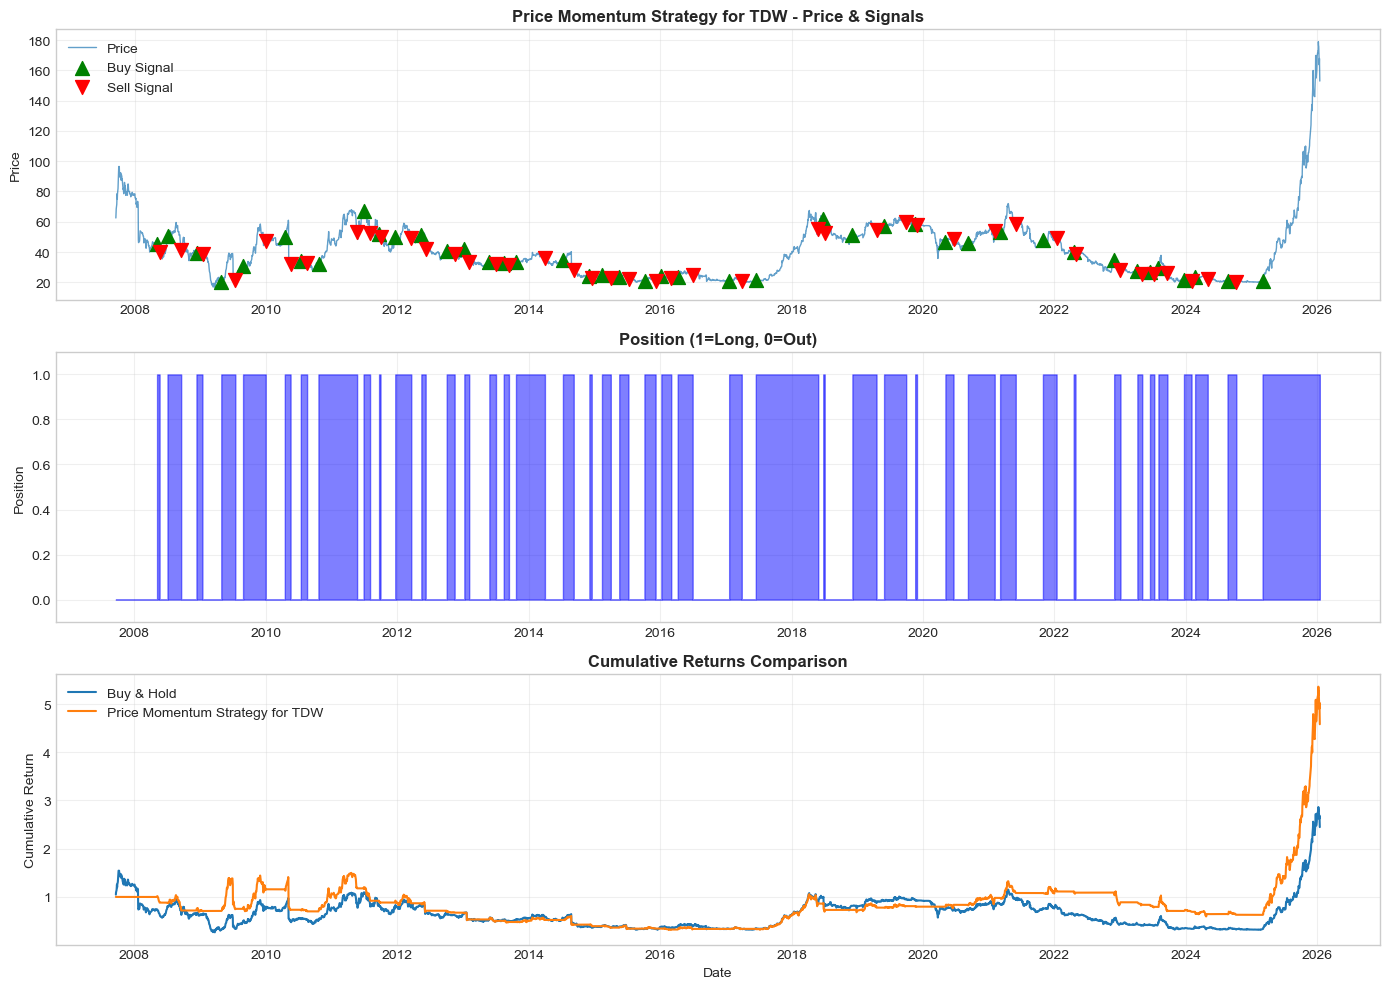

In [20]:
# Khởi tạo PriceMomentum strategy cho TDW
tdw_data = all_symbols['VIC'].dropna(subset=['adj_close']).reset_index(drop=True)
price_momentum_tdw = PriceMomentum(short_window=20, long_window=50)
result_df_tdw = price_momentum_tdw.generate_signals(tdw_data)

# in report kết quả
backtest_result_tdw = backtest_strategy(tdw_data, price_momentum_tdw, transaction_cost=0.001)
print_backtest_results(backtest_result_tdw, "Price Momentum Strategy for TDW")
plot_strategy_analysis(tdw_data, backtest_result_tdw['data'], backtest_result_tdw, "Price Momentum Strategy for TDW")


MACD Momentum Strategy for TDW
Total Return:   791.21%
Annual Return:  12.82%
Sharpe Ratio:   0.45
Max Drawdown:   -64.14%
Win Rate:       47.07%
Num Trades:     170


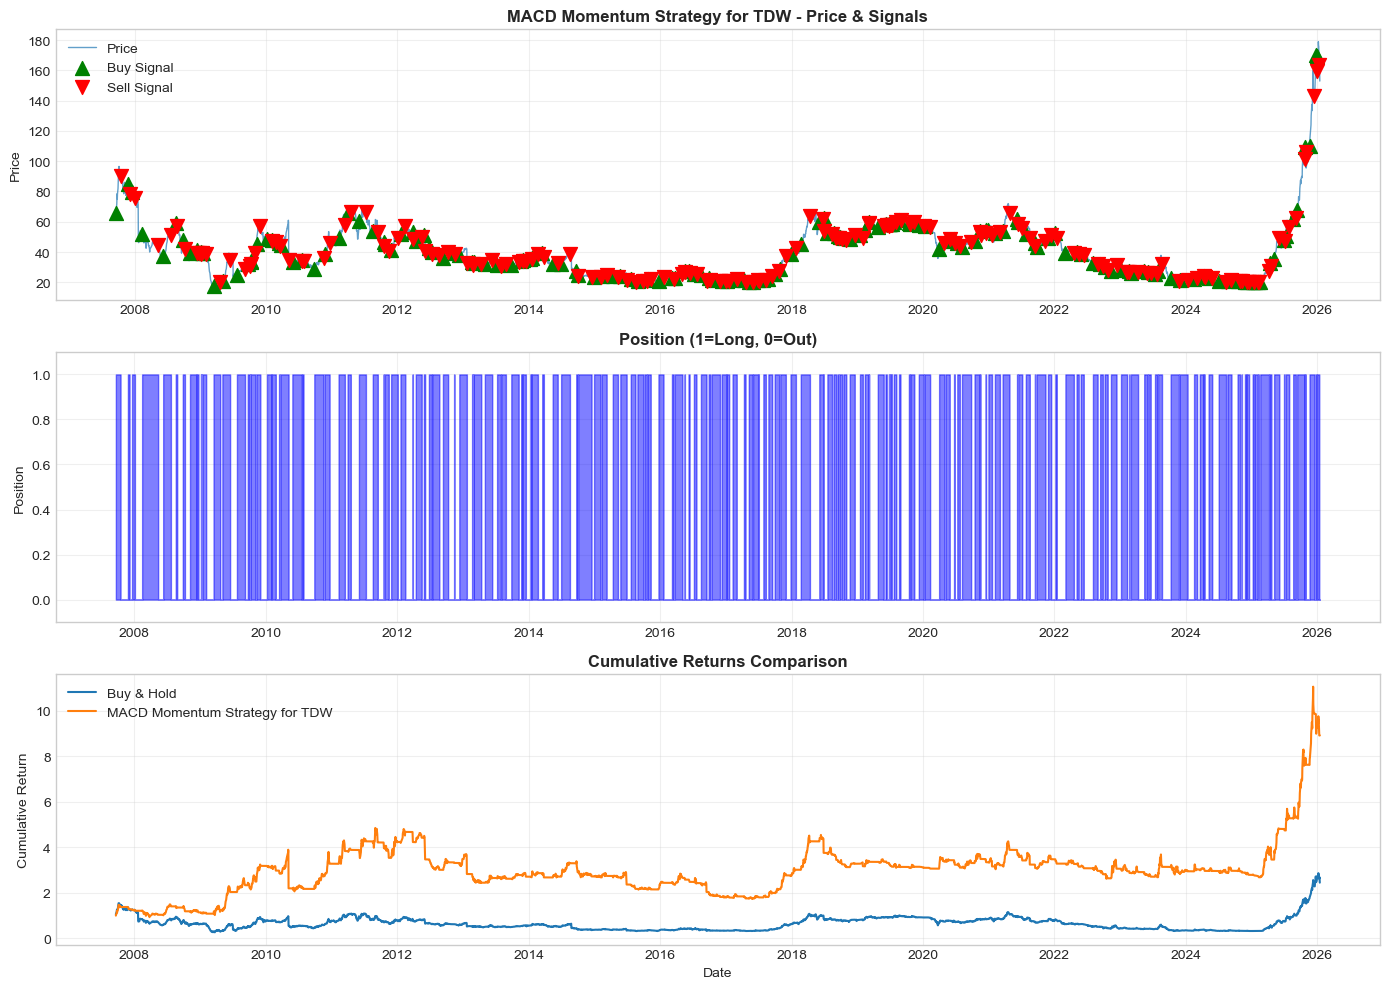

In [21]:
# Khởi tạo MACDMomentum strategy cho TDW
macd_momentum_tdw = MACDMomentum()
result_df_tdw = macd_momentum_tdw.generate_signals(tdw_data)

# in report kết quả
backtest_result_tdw = backtest_strategy(tdw_data, macd_momentum_tdw, transaction_cost=0.001)
print_backtest_results(backtest_result_tdw, "MACD Momentum Strategy for TDW")
plot_strategy_analysis(tdw_data, backtest_result_tdw['data'], backtest_result_tdw, "MACD Momentum Strategy for TDW")

## Use Optimizer 

In [22]:
# khởi tạo optimizer 
from utils import Optimizer, OptimizationStrategy

optimizer = Optimizer(
    strategy=OptimizationStrategy.BAYESIAN,
    n_trials=100,
    verbose=True,
    seed=42
)

optimizer.add_constraint('trade_count', min_trades=100, max_trades=500, ctype='hard')
optimizer.set_objective('sharpe', overfit_penalty=0.3)


# Data prepare (train/val split)
train_size = int(len(tdw_data) * 0.7)
train_data = tdw_data.iloc[:train_size].reset_index(drop=True)
val_data = tdw_data.iloc[train_size:].reset_index(drop=True)

In [23]:
# Optimize PriceMomentum strategy

param_spaces = {
    'short_window': ('int', 5, 50),   # short window between 5 and 50 days
    'long_window': ('int', 20, 200),  # long window between 20 and 200 days
}

result, optimization_history = optimizer.optimize(
    strategy_class=PriceMomentum,
    train_data=train_data,
    val_data=val_data,
    param_space=param_spaces,
    backtest_fn=backtest_strategy,
)
print("Best Parameters Found:", result['best_params'])

# Extract best params and create optimized strategy
best_params_price = result['best_params']
if best_params_price:
    best_strategy = PriceMomentum(**best_params_price)
    best_result_df = best_strategy.generate_signals(tdw_data)
    best_backtest_result = backtest_strategy(tdw_data, best_strategy, transaction_cost=0.001)
    print_backtest_results(best_backtest_result, "Optimized Price Momentum Strategy for TDW")
else:
    print("No valid parameters found during optimization")


OPTIMIZATION START - Strategy: bayesian
Constraints: 1
Trials: 100
Direction: maximize

Optimization completed in 1.1s
Best Score: 0.640632
Best Params: {'short_window': 21, 'long_window': 23}
Best Parameters Found: {'short_window': 21, 'long_window': 23}

Optimized Price Momentum Strategy for TDW
Total Return:   -2.43%
Annual Return:  -0.14%
Sharpe Ratio:   -0.00
Max Drawdown:   -83.75%
Win Rate:       45.63%
Num Trades:     180


In [24]:
# Optimize MACDMomentum strategy
param_spaces = {
    'fast': ('int', 5, 50),   # short window between 5 and 50 days
    'slow': ('int', 20, 200),  # long window between 20 and 200 days
    'signal': ('int', 5, 50),  # signal window between 5 and 50 days
}
result, optimization_history = optimizer.optimize(
    strategy_class=MACDMomentum,
    train_data=train_data,
    val_data=val_data,
    param_space=param_spaces,
    backtest_fn=backtest_strategy,
)
print("Best Parameters Found:", result['best_params'])
# Extract best params and create optimized strategy
best_params_macd = result['best_params']
if best_params_macd:
    best_strategy = MACDMomentum(**best_params_macd)
    best_result_df = best_strategy.generate_signals(tdw_data)
    best_backtest_result = backtest_strategy(tdw_data, best_strategy, transaction_cost=0.001)
    print_backtest_results(best_backtest_result, "Optimized MACD Momentum Strategy for TDW")
else:
    print("No valid parameters found during optimization")


OPTIMIZATION START - Strategy: bayesian
Constraints: 1
Trials: 100
Direction: maximize

Optimization completed in 1.7s
Best Score: 0.860693
Best Params: {'fast': 15, 'slow': 49, 'signal': 7}
Best Parameters Found: {'fast': 15, 'slow': 49, 'signal': 7}

Optimized MACD Momentum Strategy for TDW
Total Return:   849.45%
Annual Return:  13.22%
Sharpe Ratio:   0.45
Max Drawdown:   -67.99%
Win Rate:       47.93%
Num Trades:     152


In [25]:
# Optimize RSIMomentum strategy (robust to outliers - bounded 0-100)
param_spaces_rsi = {
    'period': ('int', 7, 21),        # RSI period
    'oversold': ('int', 20, 35),     # Oversold threshold
    'overbought': ('int', 65, 80),   # Overbought threshold
}

result_rsi, optimization_history_rsi = optimizer.optimize(
    strategy_class=RSIMomentum,
    train_data=train_data,
    val_data=val_data,
    param_space=param_spaces_rsi,
    backtest_fn=backtest_strategy,
)
print("Best Parameters Found:", result_rsi['best_params'])

best_params_rsi = result_rsi['best_params']
if best_params_rsi:
    best_strategy_rsi = RSIMomentum(**best_params_rsi)
    best_result_df_rsi = best_strategy_rsi.generate_signals(tdw_data)
    best_backtest_result_rsi = backtest_strategy(tdw_data, best_strategy_rsi, transaction_cost=0.001)
    print_backtest_results(best_backtest_result_rsi, "Optimized RSI Momentum Strategy for TDW")
else:
    print("No valid parameters found during optimization")


OPTIMIZATION START - Strategy: bayesian
Constraints: 1
Trials: 100
Direction: maximize

Optimization completed in 9.5s
Best Score: 0.904327
Best Params: {'period': 18, 'oversold': 35, 'overbought': 79}
Best Parameters Found: {'period': 18, 'oversold': 35, 'overbought': 79}

Optimized RSI Momentum Strategy for TDW
Total Return:   23.38%
Annual Return:  1.17%
Sharpe Ratio:   0.20
Max Drawdown:   -32.65%
Win Rate:       23.87%
Num Trades:     155


                     strategy  total_return  annual_return  volatility  \
2    RSI Momentum (long_only)      0.295301       0.048744    0.053901   
1   MACD Momentum (long_only)      2.167223       0.236220    0.274453   
0  Price Momentum (long_only)      1.499994       0.183580    0.286561   

   sharpe_ratio  max_drawdown  win_rate  num_trades    final_value  
2      0.904327     -0.057474  0.320513        39.0  129530.084476  
1      0.860693     -0.363805  0.464534        49.0  316722.279808  
0      0.640632     -0.584596  0.462462        51.5  249999.422563  


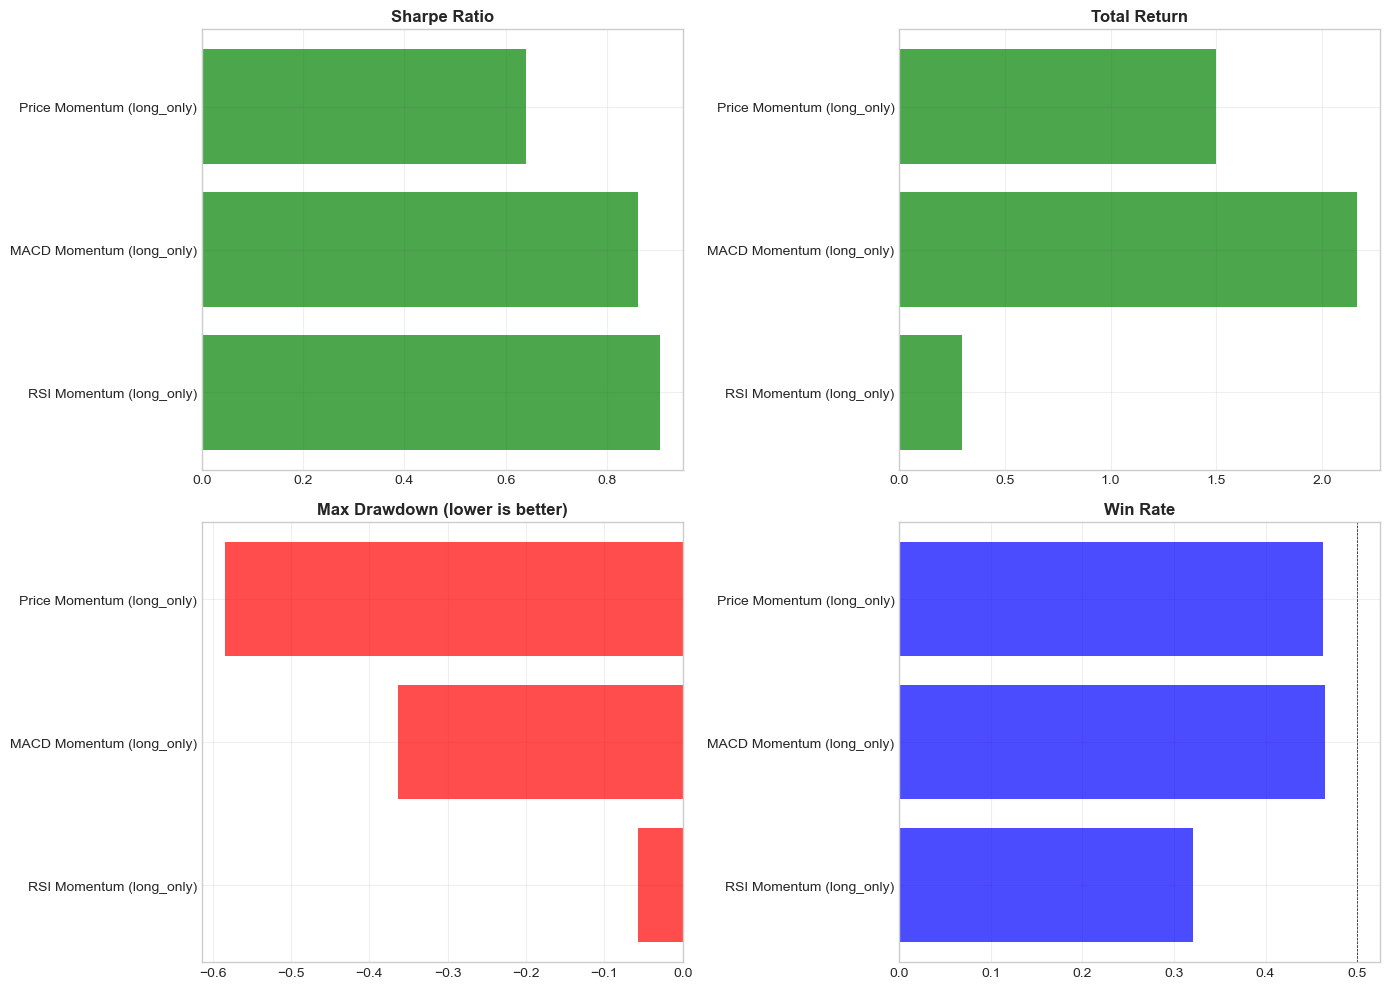

In [26]:
from strategies import compare_strategies

strategies_to_compare = [
    PriceMomentum(**best_params_price),
    MACDMomentum(**best_params_macd),
    RSIMomentum(**best_params_rsi),
]

comparison_df = compare_strategies(val_data, strategies_to_compare, transaction_cost=0.001)
print(comparison_df)
plot_comparison_charts(comparison_df)

## Parameter Sensitivity Analysis 

In [27]:
# Sensitivity Analysis for Best Parameters
def sensitivity_analysis(data, strategy_class, best_params, param_ranges, backtest_fn, transaction_cost=0.001):
    """
    Analyze sensitivity of strategy performance to parameter changes.
    
    Args:
        data: Price data
        strategy_class: Strategy class
        best_params: Best parameters found
        param_ranges: Dict of {param_name: (min, max, step)} to test
        backtest_fn: Backtest function
        transaction_cost: Transaction cost
    
    Returns:
        Dict with sensitivity results for each parameter
    """
    import numpy as np
    import pandas as pd
    
    results = {}
    
    # Test each parameter individually
    for param_name, (param_min, param_max, step) in param_ranges.items():
        if param_name not in best_params:
            continue
            
        test_values = list(range(param_min, param_max + 1, step))
        metrics = {
            'values': [],
            'sharpe': [],
            'total_return': [],
            'max_drawdown': [],
            'num_trades': []
        }
        
        for test_val in test_values:
            # Create params with one parameter varied
            test_params = best_params.copy()
            test_params[param_name] = test_val
            
            try:
                strategy = strategy_class(**test_params)
                backtest_result = backtest_fn(data, strategy, transaction_cost=transaction_cost)
                
                metrics['values'].append(test_val)
                metrics['sharpe'].append(backtest_result['sharpe_ratio'])
                metrics['total_return'].append(backtest_result['total_return'])
                metrics['max_drawdown'].append(backtest_result['max_drawdown'])
                metrics['num_trades'].append(backtest_result['num_trades'])
                
            except Exception as e:
                print(f"Error testing {param_name}={test_val}: {e}")
                continue
        
        results[param_name] = pd.DataFrame(metrics)
    
    return results


def plot_sensitivity(sensitivity_results, best_params, strategy_name):
    """Plot sensitivity analysis results."""
    import matplotlib.pyplot as plt
    
    n_params = len(sensitivity_results)
    fig, axes = plt.subplots(n_params, 2, figsize=(14, 4 * n_params))
    
    if n_params == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (param_name, df) in enumerate(sensitivity_results.items()):
        best_val = best_params[param_name]
        
        # Plot 1: Sharpe Ratio
        axes[idx, 0].plot(df['values'], df['sharpe'], marker='o', linewidth=2)
        axes[idx, 0].axvline(x=best_val, color='red', linestyle='--', label=f'Best: {best_val}', linewidth=2)
        axes[idx, 0].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        axes[idx, 0].set_xlabel(param_name, fontsize=11)
        axes[idx, 0].set_ylabel('Sharpe Ratio', fontsize=11)
        axes[idx, 0].set_title(f'{strategy_name} - Sharpe Sensitivity to {param_name}', fontsize=12, fontweight='bold')
        axes[idx, 0].legend()
        axes[idx, 0].grid(True, alpha=0.3)
        
        # Plot 2: Total Return
        axes[idx, 1].plot(df['values'], [x*100 for x in df['total_return']], marker='o', linewidth=2, color='green')
        axes[idx, 1].axvline(x=best_val, color='red', linestyle='--', label=f'Best: {best_val}', linewidth=2)
        axes[idx, 1].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        axes[idx, 1].set_xlabel(param_name, fontsize=11)
        axes[idx, 1].set_ylabel('Total Return (%)', fontsize=11)
        axes[idx, 1].set_title(f'{strategy_name} - Return Sensitivity to {param_name}', fontsize=12, fontweight='bold')
        axes[idx, 1].legend()
        axes[idx, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def print_sensitivity_summary(sensitivity_results, best_params):
    """Print summary statistics for sensitivity analysis."""
    print("\n" + "="*80)
    print("SENSITIVITY ANALYSIS SUMMARY")
    print("="*80)
    
    for param_name, df in sensitivity_results.items():
        best_val = best_params[param_name]
        best_idx = df[df['values'] == best_val].index[0] if best_val in df['values'].values else None
        
        print(f"\n{param_name.upper()}")
        print("-" * 50)
        print(f"Best Value: {best_val}")
        
        if best_idx is not None:
            best_sharpe = df.loc[best_idx, 'sharpe']
            print(f"Best Sharpe: {best_sharpe:.4f}")
            
            # Calculate range of Sharpe within ±20% of best param
            lower_bound = int(best_val * 0.8)
            upper_bound = int(best_val * 1.2)
            nearby_df = df[(df['values'] >= lower_bound) & (df['values'] <= upper_bound)]
            
            if len(nearby_df) > 1:
                sharpe_std = nearby_df['sharpe'].std()
                sharpe_range = nearby_df['sharpe'].max() - nearby_df['sharpe'].min()
                print(f"Sharpe Std Dev (±20%): {sharpe_std:.4f}")
                print(f"Sharpe Range (±20%): {sharpe_range:.4f}")
                print(f"Sensitivity Score: {'HIGH' if sharpe_range > 0.5 else 'MEDIUM' if sharpe_range > 0.2 else 'LOW'}")
            
            # Show top 5 alternatives
            top_5 = df.nlargest(5, 'sharpe')[['values', 'sharpe', 'total_return', 'num_trades']]
            print(f"\nTop 5 Parameter Values:")
            for _, row in top_5.iterrows():
                marker = " ← BEST" if row['values'] == best_val else ""
                print(f"  {param_name}={int(row['values'])}: Sharpe={row['sharpe']:.4f}, Return={row['total_return']:.2%}, Trades={int(row['num_trades'])}{marker}")


Running sensitivity analysis for PriceMomentum...
Best params: {'short_window': 21, 'long_window': 23}
Testing ranges: {'short_window': (10, 31, 1), 'long_window': (20, 34, 1)}

SENSITIVITY ANALYSIS SUMMARY

SHORT_WINDOW
--------------------------------------------------
Best Value: 21
Best Sharpe: -0.2389
Sharpe Std Dev (±20%): 0.0892
Sharpe Range (±20%): 0.2914
Sensitivity Score: MEDIUM

Top 5 Parameter Values:
  short_window=13: Sharpe=0.0329, Return=13.23%, Trades=80
  short_window=14: Sharpe=0.0165, Return=6.43%, Trades=83
  short_window=12: Sharpe=0.0106, Return=4.06%, Trades=79
  short_window=23: Sharpe=0.0000, Return=0.00%, Trades=0
  short_window=16: Sharpe=-0.0243, Return=-8.81%, Trades=85

LONG_WINDOW
--------------------------------------------------
Best Value: 23
Best Sharpe: -0.2389
Sharpe Std Dev (±20%): 0.0872
Sharpe Range (±20%): 0.2965
Sensitivity Score: MEDIUM

Top 5 Parameter Values:
  long_window=21: Sharpe=0.0000, Return=0.00%, Trades=0
  long_window=33: Sharpe=-

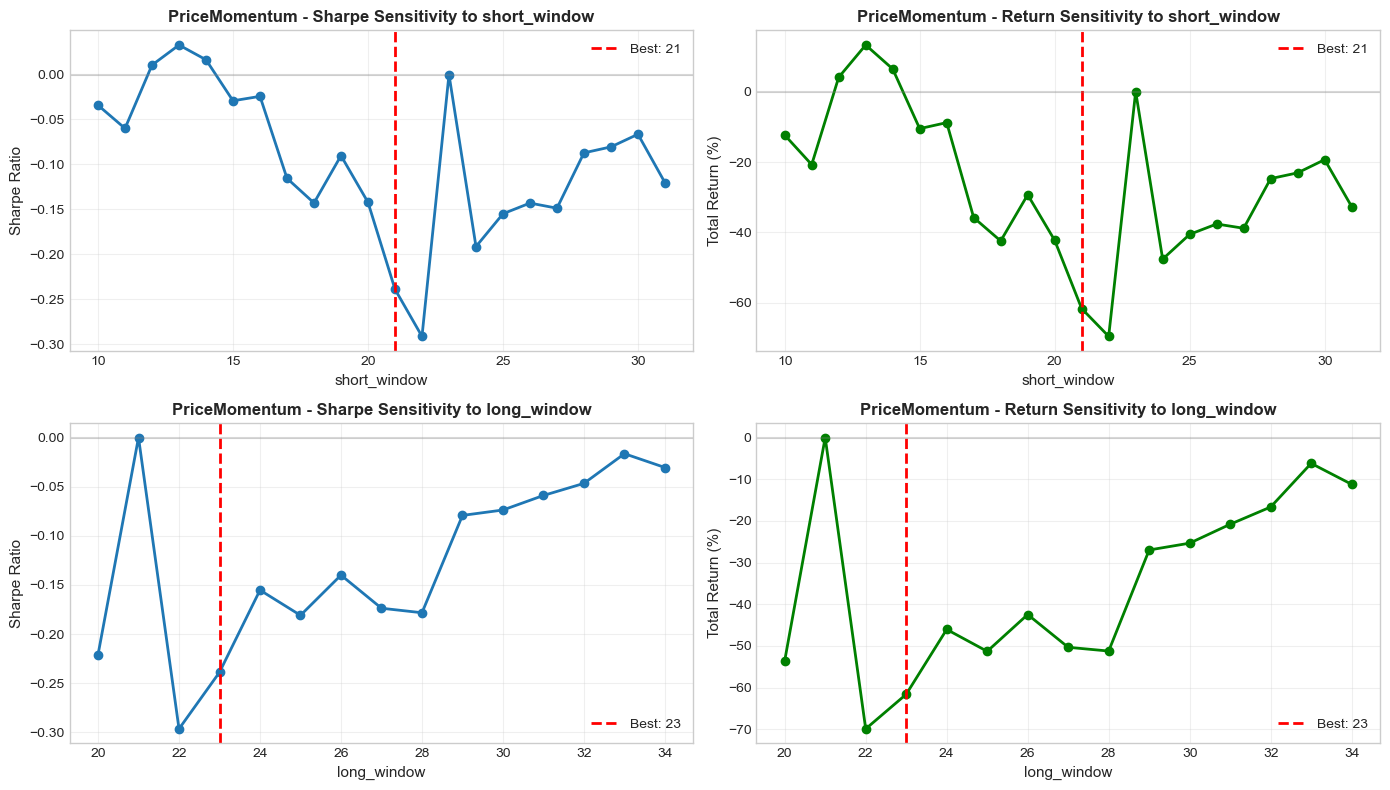

In [33]:
# ============================================================
# SENSITIVITY ANALYSIS - Price Momentum
# ============================================================

# Define ranges to test around best params (±50% with step)
param_ranges_price = {
    'short_window': (max(5, int(best_params_price['short_window'] * 0.5)), 
                     min(50, int(best_params_price['short_window'] * 1.5)), 
                     1),  # Test every 2 days
    'long_window': (max(20, int(best_params_price['long_window'] * 0.5)), 
                    min(200, int(best_params_price['long_window'] * 1.5)), 
                    1),  # Test every 5 days
}

print("Running sensitivity analysis for PriceMomentum...")
print(f"Best params: {best_params_price}")
print(f"Testing ranges: {param_ranges_price}")

sensitivity_price = sensitivity_analysis(
    data=train_data,
    strategy_class=PriceMomentum,
    best_params=best_params_price,
    param_ranges=param_ranges_price,
    backtest_fn=backtest_strategy,
    transaction_cost=0.001
)

print_sensitivity_summary(sensitivity_price, best_params_price)
plot_sensitivity(sensitivity_price, best_params_price, "PriceMomentum")

Running sensitivity analysis for MACDMomentum...
Best params: {'fast': 15, 'slow': 49, 'signal': 7}
Testing ranges: {'fast': (12, 18, 2), 'slow': (39, 58, 2), 'signal': (5, 8, 2)}

SENSITIVITY ANALYSIS SUMMARY

FAST
--------------------------------------------------
Best Value: 15

SLOW
--------------------------------------------------
Best Value: 49
Best Sharpe: 0.2866
Sharpe Std Dev (±20%): 0.0345
Sharpe Range (±20%): 0.0865
Sensitivity Score: LOW

Top 5 Parameter Values:
  slow=51: Sharpe=0.3288, Return=230.31%, Trades=102
  slow=53: Sharpe=0.3199, Return=219.29%, Trades=102
  slow=55: Sharpe=0.3197, Return=219.07%, Trades=101
  slow=57: Sharpe=0.3197, Return=219.01%, Trades=103
  slow=49: Sharpe=0.2866, Return=187.29%, Trades=103 ← BEST

SIGNAL
--------------------------------------------------
Best Value: 7
Best Sharpe: 0.2866
Sharpe Std Dev (±20%): 0.0099
Sharpe Range (±20%): 0.0140
Sensitivity Score: LOW

Top 5 Parameter Values:
  signal=7: Sharpe=0.2866, Return=187.29%, Trades

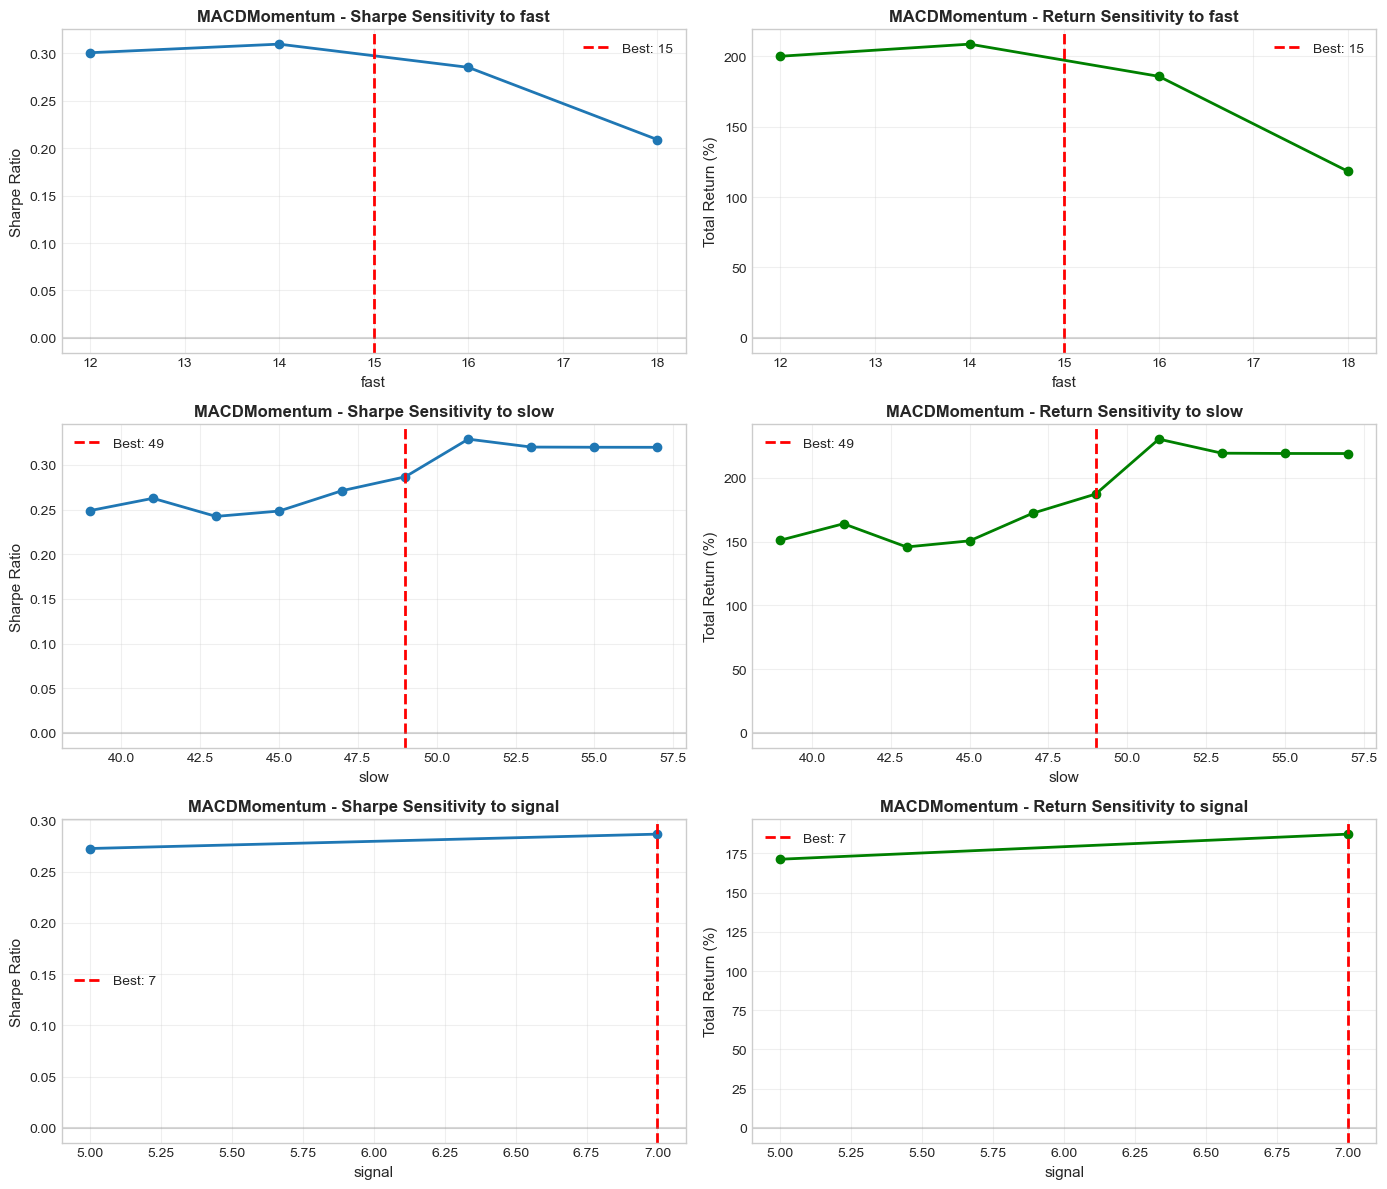

In [31]:
# ============================================================
# SENSITIVITY ANALYSIS - MACD Momentum
# ============================================================

# Define ranges to test around best params (±20% with step)
param_ranges_macd = {
    'fast': (max(5, int(best_params_macd['fast'] * 0.8)), 
             min(50, int(best_params_macd['fast'] * 1.2)), 
             2),  # Test every 2 days
    'slow': (max(20, int(best_params_macd['slow'] * 0.8)), 
             min(200, int(best_params_macd['slow'] * 1.2)), 
             2),  # Test every 2 days
    'signal': (max(5, int(best_params_macd['signal'] * 0.8)), 
               min(50, int(best_params_macd['signal'] * 1.2)), 
               2),  # Test every 2 days
}
print("Running sensitivity analysis for MACDMomentum...")
print(f"Best params: {best_params_macd}")
print(f"Testing ranges: {param_ranges_macd}")
sensitivity_macd = sensitivity_analysis(
    data=train_data,
    strategy_class=MACDMomentum,
    best_params=best_params_macd,
    param_ranges=param_ranges_macd,
    backtest_fn=backtest_strategy,
    transaction_cost=0.001
)
print_sensitivity_summary(sensitivity_macd, best_params_macd)
plot_sensitivity(sensitivity_macd, best_params_macd, "MACDMomentum")


Running sensitivity analysis for RSIMomentum...
Best params: {'period': 18, 'oversold': 35, 'overbought': 79}
Testing ranges: {'period': (14, 21, 1), 'oversold': (28, 35, 1), 'overbought': (65, 80, 1)}

SENSITIVITY ANALYSIS SUMMARY

PERIOD
--------------------------------------------------
Best Value: 18
Best Sharpe: -0.0686
Sharpe Std Dev (±20%): 0.1416
Sharpe Range (±20%): 0.5111
Sensitivity Score: HIGH

Top 5 Parameter Values:
  period=16: Sharpe=0.2150, Return=17.03%, Trades=121
  period=15: Sharpe=0.0210, Return=1.57%, Trades=123
  period=21: Sharpe=0.0179, Return=1.27%, Trades=92
  period=20: Sharpe=-0.0246, Return=-1.81%, Trades=93
  period=19: Sharpe=-0.0417, Return=-3.50%, Trades=104

OVERSOLD
--------------------------------------------------
Best Value: 35
Best Sharpe: -0.0686
Sharpe Std Dev (±20%): 0.1408
Sharpe Range (±20%): 0.4408
Sensitivity Score: MEDIUM

Top 5 Parameter Values:
  oversold=32: Sharpe=0.3531, Return=28.78%, Trades=95
  oversold=31: Sharpe=0.1065, Return=

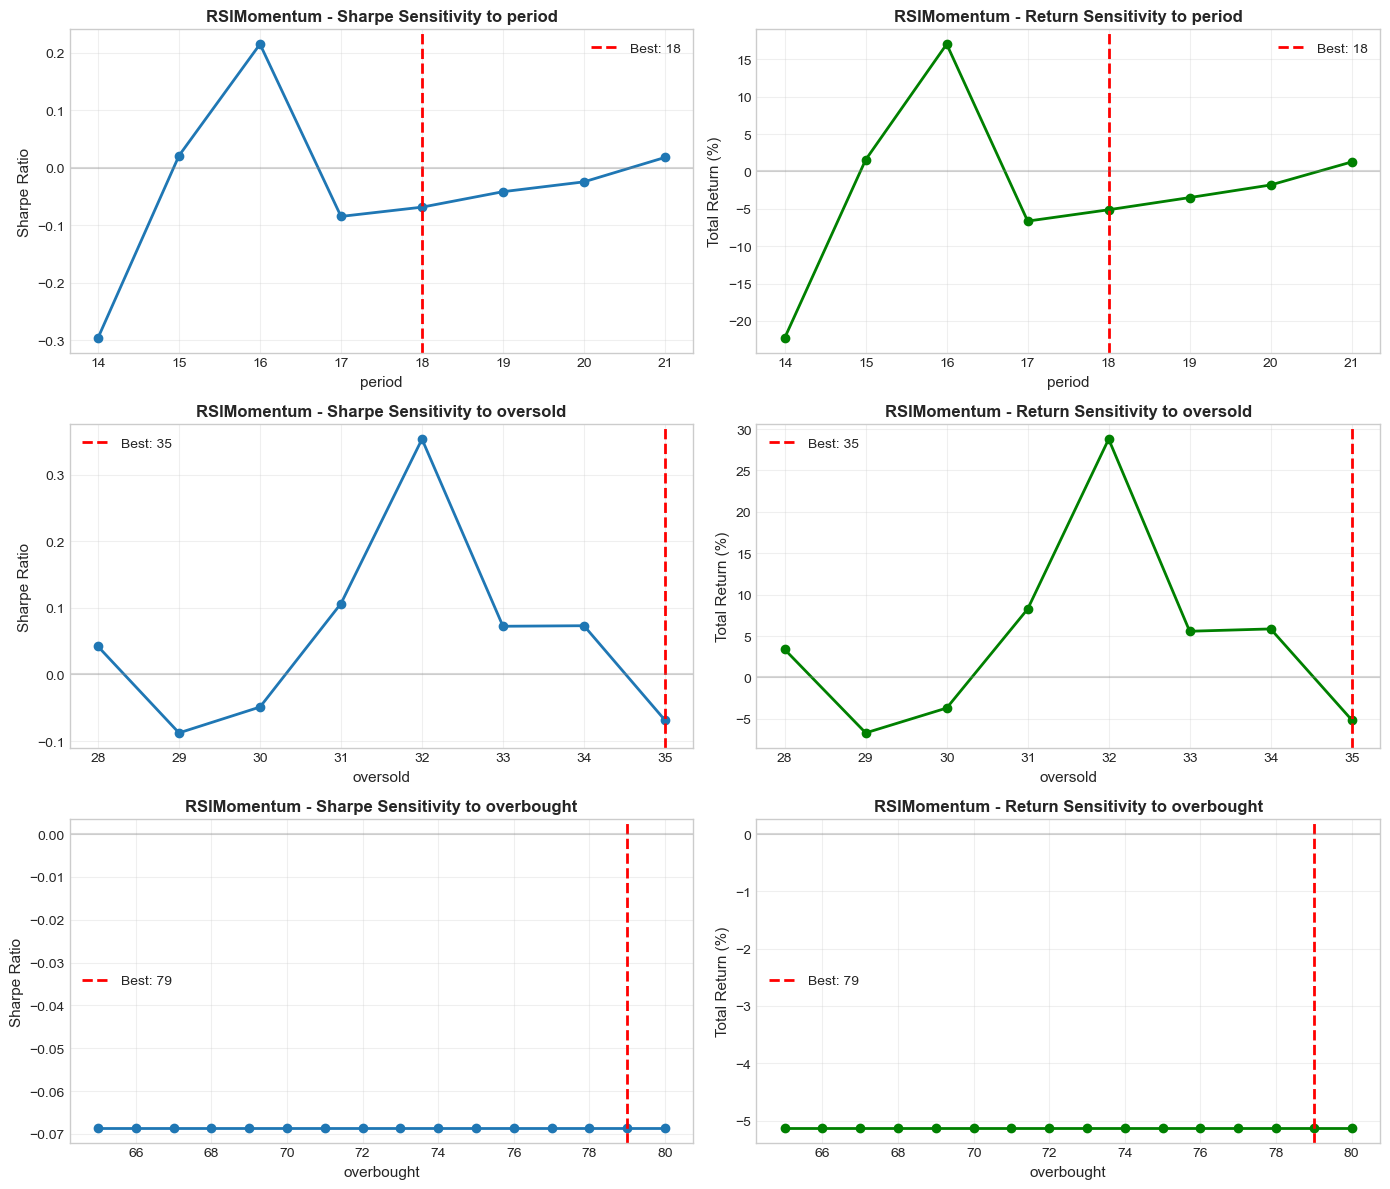

In [30]:
# ============================================================
# SENSITIVITY ANALYSIS - RSI Momentum
# ============================================================
# Define ranges to test around best params (±20% with step)
param_ranges_rsi = {
    'period': (max(7, int(best_params_rsi['period'] * 0.8)), 
               min(21, int(best_params_rsi['period'] * 1.2)), 
               1),  # Test every 1 day
    'oversold': (max(20, int(best_params_rsi['oversold'] * 0.8)), 
                  min(35, int(best_params_rsi['oversold'] * 1.2)), 
                  1),  # Test every 1 point
    'overbought': (max(65, int(best_params_rsi['overbought'] * 0.8)), 
                    min(80, int(best_params_rsi['overbought'] * 1.2)), 
                    1),  # Test every 1 point
}
print("Running sensitivity analysis for RSIMomentum...")
print(f"Best params: {best_params_rsi}")
print(f"Testing ranges: {param_ranges_rsi}")
sensitivity_rsi = sensitivity_analysis(
    data=train_data,
    strategy_class=RSIMomentum,
    best_params=best_params_rsi,
    param_ranges=param_ranges_rsi,
    backtest_fn=backtest_strategy,
    transaction_cost=0.001
)
print_sensitivity_summary(sensitivity_rsi, best_params_rsi)
plot_sensitivity(sensitivity_rsi, best_params_rsi, "RSIMomentum")

# Strategy on universe

In [34]:
# ============================================================
# STABILITY ANALYSIS FUNCTION
# ============================================================

def calculate_stability_score(sensitivity_results, best_params, backtest_result, train_result, val_result):
    """
    Calculate stability score for a strategy based on multiple factors:
    1. Parameter sensitivity (how much performance changes with parameters)
    2. Overfitting (train vs validation performance gap)
    3. Consistency (variance in performance across parameter range)
    
    Args:
        sensitivity_results: Dict of sensitivity analysis results
        best_params: Best parameters found
        backtest_result: Full dataset backtest result
        train_result: Training set backtest result
        val_result: Validation set backtest result
    
    Returns:
        Dict with stability metrics and overall score
    """
    stability_metrics = {}
    
    # 1. Parameter Sensitivity Score (0-100, higher is better = less sensitive)
    param_sensitivity_scores = []
    for param_name, df in sensitivity_results.items():
        best_val = best_params[param_name]
        best_idx = df[df['values'] == best_val].index[0] if best_val in df['values'].values else None
        
        if best_idx is not None:
            best_sharpe = df.loc[best_idx, 'sharpe']
            
            # Calculate range of Sharpe within ±20% of best param
            lower_bound = int(best_val * 0.8)
            upper_bound = int(best_val * 1.2)
            nearby_df = df[(df['values'] >= lower_bound) & (df['values'] <= upper_bound)]
            
            if len(nearby_df) > 1:
                sharpe_std = nearby_df['sharpe'].std()
                sharpe_range = nearby_df['sharpe'].max() - nearby_df['sharpe'].min()
                
                # Lower std and range = more stable = higher score
                # Normalize: if sharpe_range > 1.0, score = 0; if sharpe_range = 0, score = 100
                sensitivity_score = max(0, 100 - (sharpe_range * 100))
                param_sensitivity_scores.append(sensitivity_score)
                
                stability_metrics[f'{param_name}_sensitivity'] = sharpe_range
                stability_metrics[f'{param_name}_std'] = sharpe_std
    
    # Average sensitivity score across all parameters
    avg_sensitivity_score = np.mean(param_sensitivity_scores) if param_sensitivity_scores else 50
    stability_metrics['parameter_sensitivity_score'] = avg_sensitivity_score
    
    # 2. Overfitting Score (0-100, higher is better = less overfitting)
    train_sharpe = train_result['sharpe_ratio']
    val_sharpe = val_result['sharpe_ratio']
    
    # Calculate overfitting gap
    if train_sharpe > 0:
        overfitting_gap = abs(train_sharpe - val_sharpe) / train_sharpe
    else:
        overfitting_gap = 1.0  # Maximum overfitting if train sharpe is 0 or negative
    
    # Convert to score (lower gap = higher score)
    # If gap > 0.5 (50%), score = 0; if gap = 0, score = 100
    overfitting_score = max(0, 100 - (overfitting_gap * 200))
    stability_metrics['overfitting_score'] = overfitting_score
    stability_metrics['train_sharpe'] = train_sharpe
    stability_metrics['val_sharpe'] = val_sharpe
    stability_metrics['overfitting_gap'] = overfitting_gap
    
    # 3. Consistency Score - check if strategy performs well across different metrics
    # Use coefficient of variation of key metrics
    metrics_values = [
        abs(train_result['sharpe_ratio']),
        abs(val_result['sharpe_ratio']),
        train_result['win_rate'],
        val_result['win_rate']
    ]
    
    # Filter out zeros to avoid division issues
    metrics_values = [x for x in metrics_values if x > 0]
    
    if len(metrics_values) >= 2:
        cv = np.std(metrics_values) / np.mean(metrics_values)  # Coefficient of variation
        # Lower CV = more consistent = higher score
        consistency_score = max(0, 100 - (cv * 50))
    else:
        consistency_score = 50
    
    stability_metrics['consistency_score'] = consistency_score
    
    # 4. Overall Stability Score (weighted average)
    overall_stability_score = (
        avg_sensitivity_score * 0.4 +  # 40% weight on parameter stability
        overfitting_score * 0.4 +       # 40% weight on overfitting
        consistency_score * 0.2         # 20% weight on consistency
    )
    
    stability_metrics['overall_stability_score'] = overall_stability_score
    
    # 5. Stability Rating
    if overall_stability_score >= 80:
        rating = "EXCELLENT"
    elif overall_stability_score >= 65:
        rating = "GOOD"
    elif overall_stability_score >= 50:
        rating = "MODERATE"
    elif overall_stability_score >= 35:
        rating = "POOR"
    else:
        rating = "VERY POOR"
    
    stability_metrics['stability_rating'] = rating
    
    return stability_metrics


def print_stability_report(stability_metrics, strategy_name):
    """Print comprehensive stability report."""
    print("\n" + "="*80)
    print(f"STABILITY REPORT: {strategy_name}")
    print("="*80)
    
    print(f"\n📊 OVERALL STABILITY SCORE: {stability_metrics['overall_stability_score']:.1f}/100")
    print(f"   Rating: {stability_metrics['stability_rating']}")
    
    print(f"\n🔧 Parameter Sensitivity Score: {stability_metrics['parameter_sensitivity_score']:.1f}/100")
    print("   (Higher = parameters are more stable)")
    for key, value in stability_metrics.items():
        if '_sensitivity' in key:
            param_name = key.replace('_sensitivity', '')
            print(f"   - {param_name}: Sharpe range = {value:.4f}")
    
    print(f"\n🎯 Overfitting Score: {stability_metrics['overfitting_score']:.1f}/100")
    print("   (Higher = less overfitting)")
    print(f"   - Train Sharpe: {stability_metrics['train_sharpe']:.4f}")
    print(f"   - Val Sharpe: {stability_metrics['val_sharpe']:.4f}")
    print(f"   - Gap: {stability_metrics['overfitting_gap']:.2%}")
    
    print(f"\n📈 Consistency Score: {stability_metrics['consistency_score']:.1f}/100")
    print("   (Higher = more consistent across metrics)")
    
    print("\n" + "="*80)


print("Stability analysis functions defined successfully!")


Stability analysis functions defined successfully!


In [35]:
# ============================================================
# UNIVERSE OPTIMIZATION
# ============================================================

def optimize_strategy_on_universe(
    all_symbols_data,
    strategy_class,
    param_space,
    optimizer,
    n_stocks=10,
    min_data_points=500,
    transaction_cost=0.001
):
    """
    Optimize a strategy on multiple stocks from universe.
    
    Args:
        all_symbols_data: Dict of {symbol: dataframe}
        strategy_class: Strategy class to optimize
        param_space: Parameter space for optimization
        optimizer: Optimizer instance
        n_stocks: Number of stocks to test (None = all)
        min_data_points: Minimum data points required
        transaction_cost: Transaction cost
    
    Returns:
        Dict with optimization results per symbol
    """
    results = {}
    
    # Filter stocks with enough data
    valid_symbols = []
    for symbol, df in all_symbols_data.items():
        if len(df) >= min_data_points:
            valid_symbols.append(symbol)
    
    print(f"\n{'='*80}")
    print(f"OPTIMIZING {strategy_class.__name__} ON UNIVERSE")
    print(f"{'='*80}")
    print(f"Valid symbols: {len(valid_symbols)}")
    
    # Sample stocks if needed
    if n_stocks and len(valid_symbols) > n_stocks:
        import random
        random.seed(42)
        test_symbols = random.sample(valid_symbols, n_stocks)
    else:
        test_symbols = valid_symbols
    
    print(f"Testing on: {len(test_symbols)} stocks")
    print(f"Symbols: {', '.join(test_symbols)}")
    
    # Optimize on each stock
    for idx, symbol in enumerate(test_symbols, 1):
        print(f"\n[{idx}/{len(test_symbols)}] Optimizing {symbol}...")
        
        df = all_symbols_data[symbol].dropna(subset=['adj_close']).reset_index(drop=True)
        
        # Train/val split
        train_size = int(len(df) * 0.7)
        train_data = df.iloc[:train_size].reset_index(drop=True)
        val_data = df.iloc[train_size:].reset_index(drop=True)
        
        try:
            # Optimize
            result, opt_history = optimizer.optimize(
                strategy_class=strategy_class,
                train_data=train_data,
                val_data=val_data,
                param_space=param_space,
                backtest_fn=backtest_strategy,
            )
            
            if result['best_params']:
                # Test on full data
                best_strategy = strategy_class(**result['best_params'])
                full_backtest = backtest_strategy(df, best_strategy, transaction_cost=transaction_cost)
                train_backtest = backtest_strategy(train_data, best_strategy, transaction_cost=transaction_cost)
                val_backtest = backtest_strategy(val_data, best_strategy, transaction_cost=transaction_cost)
                
                results[symbol] = {
                    'best_params': result['best_params'],
                    'full_backtest': full_backtest,
                    'train_backtest': train_backtest,
                    'val_backtest': val_backtest,
                    'opt_history': opt_history
                }
                
                print(f"   ✓ Best params: {result['best_params']}")
                print(f"   ✓ Train Sharpe: {train_backtest['sharpe_ratio']:.3f}")
                print(f"   ✓ Val Sharpe: {val_backtest['sharpe_ratio']:.3f}")
                print(f"   ✓ Full Sharpe: {full_backtest['sharpe_ratio']:.3f}")
            else:
                print(f"   ✗ No valid parameters found")
                
        except Exception as e:
            print(f"   ✗ Error: {str(e)}")
            continue
    
    return results


def run_sensitivity_on_universe_results(
    all_symbols_data,
    universe_results,
    strategy_class,
    param_ranges_func,
    transaction_cost=0.001
):
    """
    Run sensitivity analysis on universe optimization results.
    
    Args:
        all_symbols_data: Dict of {symbol: dataframe}
        universe_results: Results from optimize_strategy_on_universe
        strategy_class: Strategy class
        param_ranges_func: Function that takes best_params and returns param_ranges
        transaction_cost: Transaction cost
    
    Returns:
        Dict with sensitivity results and stability metrics per symbol
    """
    sensitivity_results = {}
    
    print(f"\n{'='*80}")
    print(f"SENSITIVITY ANALYSIS ON UNIVERSE RESULTS")
    print(f"{'='*80}")
    
    for idx, (symbol, result) in enumerate(universe_results.items(), 1):
        print(f"\n[{idx}/{len(universe_results)}] Analyzing {symbol}...")
        
        df = all_symbols_data[symbol].dropna(subset=['adj_close']).reset_index(drop=True)
        train_size = int(len(df) * 0.7)
        train_data = df.iloc[:train_size].reset_index(drop=True)
        
        best_params = result['best_params']
        param_ranges = param_ranges_func(best_params)
        
        try:
            # Run sensitivity analysis
            sensitivity = sensitivity_analysis(
                data=train_data,
                strategy_class=strategy_class,
                best_params=best_params,
                param_ranges=param_ranges,
                backtest_fn=backtest_strategy,
                transaction_cost=transaction_cost
            )
            
            # Calculate stability score
            stability_metrics = calculate_stability_score(
                sensitivity_results=sensitivity,
                best_params=best_params,
                backtest_result=result['full_backtest'],
                train_result=result['train_backtest'],
                val_result=result['val_backtest']
            )
            
            sensitivity_results[symbol] = {
                'sensitivity': sensitivity,
                'stability_metrics': stability_metrics,
                'best_params': best_params,
                'full_backtest': result['full_backtest'],
                'train_backtest': result['train_backtest'],
                'val_backtest': result['val_backtest']
            }
            
            print(f"   ✓ Stability Score: {stability_metrics['overall_stability_score']:.1f}/100")
            print(f"   ✓ Rating: {stability_metrics['stability_rating']}")
            
        except Exception as e:
            print(f"   ✗ Error: {str(e)}")
            continue
    
    return sensitivity_results


def create_universe_summary(sensitivity_results, strategy_name):
    """Create summary dataframe of universe results."""
    summary_data = []
    
    for symbol, result in sensitivity_results.items():
        stability = result['stability_metrics']
        full = result['full_backtest']
        train = result['train_backtest']
        val = result['val_backtest']
        
        summary_data.append({
            'Symbol': symbol,
            'Stability_Score': stability['overall_stability_score'],
            'Stability_Rating': stability['stability_rating'],
            'Param_Sensitivity': stability['parameter_sensitivity_score'],
            'Overfitting_Score': stability['overfitting_score'],
            'Consistency_Score': stability['consistency_score'],
            'Full_Sharpe': full['sharpe_ratio'],
            'Train_Sharpe': train['sharpe_ratio'],
            'Val_Sharpe': val['sharpe_ratio'],
            'Full_Return': full['total_return'],
            'Win_Rate': full['win_rate'],
            'Max_Drawdown': full['max_drawdown'],
            'Num_Trades': full['num_trades']
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('Stability_Score', ascending=False)
    
    return summary_df


def plot_universe_stability_comparison(summary_df, strategy_name):
    """Plot comparison charts for universe stability analysis."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Sort by stability score
    plot_df = summary_df.sort_values('Stability_Score', ascending=True)
    
    # 1. Stability Score
    colors = ['green' if x >= 65 else 'orange' if x >= 50 else 'red' 
              for x in plot_df['Stability_Score']]
    axes[0, 0].barh(plot_df['Symbol'], plot_df['Stability_Score'], color=colors, alpha=0.7)
    axes[0, 0].axvline(x=65, color='green', linestyle='--', alpha=0.5, label='Good threshold')
    axes[0, 0].axvline(x=50, color='orange', linestyle='--', alpha=0.5, label='Moderate threshold')
    axes[0, 0].set_xlabel('Stability Score')
    axes[0, 0].set_title(f'{strategy_name} - Overall Stability Score', fontsize=12, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Component Scores
    x = np.arange(len(plot_df))
    width = 0.25
    
    axes[0, 1].barh(x - width, plot_df['Param_Sensitivity'], width, label='Param Stability', alpha=0.7)
    axes[0, 1].barh(x, plot_df['Overfitting_Score'], width, label='Anti-Overfitting', alpha=0.7)
    axes[0, 1].barh(x + width, plot_df['Consistency_Score'], width, label='Consistency', alpha=0.7)
    axes[0, 1].set_yticks(x)
    axes[0, 1].set_yticklabels(plot_df['Symbol'])
    axes[0, 1].set_xlabel('Score')
    axes[0, 1].set_title('Stability Components', fontsize=12, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Sharpe Ratios (Train vs Val)
    x = np.arange(len(plot_df))
    width = 0.35
    
    axes[1, 0].barh(x - width/2, plot_df['Train_Sharpe'], width, label='Train', alpha=0.7, color='blue')
    axes[1, 0].barh(x + width/2, plot_df['Val_Sharpe'], width, label='Validation', alpha=0.7, color='orange')
    axes[1, 0].set_yticks(x)
    axes[1, 0].set_yticklabels(plot_df['Symbol'])
    axes[1, 0].set_xlabel('Sharpe Ratio')
    axes[1, 0].set_title('Train vs Validation Sharpe', fontsize=12, fontweight='bold')
    axes[1, 0].axvline(x=0, color='black', linewidth=0.5)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Performance vs Stability
    colors_scatter = ['green' if x >= 65 else 'orange' if x >= 50 else 'red' 
                      for x in summary_df['Stability_Score']]
    axes[1, 1].scatter(summary_df['Stability_Score'], summary_df['Full_Sharpe'], 
                       c=colors_scatter, s=100, alpha=0.6)
    
    for idx, row in summary_df.iterrows():
        axes[1, 1].annotate(row['Symbol'], 
                           (row['Stability_Score'], row['Full_Sharpe']),
                           fontsize=8, alpha=0.7)
    
    axes[1, 1].set_xlabel('Stability Score')
    axes[1, 1].set_ylabel('Full Dataset Sharpe Ratio')
    axes[1, 1].set_title('Performance vs Stability', fontsize=12, fontweight='bold')
    axes[1, 1].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    axes[1, 1].axvline(x=50, color='orange', linestyle='--', alpha=0.3)
    axes[1, 1].axvline(x=65, color='green', linestyle='--', alpha=0.3)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


print("Universe optimization functions defined successfully!")


Universe optimization functions defined successfully!


## Run optimization on universe for 3 strategies

In [36]:
# Define parameter ranges functions for sensitivity analysis
def get_price_momentum_sensitivity_ranges(best_params):
    """Get sensitivity ranges for PriceMomentum around best params."""
    return {
        'short_window': (max(5, int(best_params['short_window'] * 0.8)), 
                        min(50, int(best_params['short_window'] * 1.2)), 
                        2),
        'long_window': (max(20, int(best_params['long_window'] * 0.8)), 
                       min(200, int(best_params['long_window'] * 1.2)), 
                       5),
    }

def get_macd_momentum_sensitivity_ranges(best_params):
    """Get sensitivity ranges for MACDMomentum around best params."""
    return {
        'fast': (max(5, int(best_params['fast'] * 0.8)), 
                min(50, int(best_params['fast'] * 1.2)), 
                2),
        'slow': (max(20, int(best_params['slow'] * 0.8)), 
                min(200, int(best_params['slow'] * 1.2)), 
                5),
        'signal': (max(5, int(best_params['signal'] * 0.8)), 
                  min(50, int(best_params['signal'] * 1.2)), 
                  2),
    }

def get_rsi_momentum_sensitivity_ranges(best_params):
    """Get sensitivity ranges for RSIMomentum around best params."""
    return {
        'period': (max(7, int(best_params['period'] * 0.8)), 
                  min(21, int(best_params['period'] * 1.2)), 
                  1),
        'oversold': (max(20, int(best_params['oversold'] * 0.8)), 
                    min(35, int(best_params['oversold'] * 1.2)), 
                    1),
        'overbought': (max(65, int(best_params['overbought'] * 0.8)), 
                      min(80, int(best_params['overbought'] * 1.2)), 
                      1),
    }

print("Sensitivity range functions defined!")


Sensitivity range functions defined!


In [39]:
# ============================================================
# 1. OPTIMIZE PRICEMOMENTUM ON UNIVERSE
# ============================================================

param_spaces_price = {
    'short_window': ('int', 5, 50),
    'long_window': ('int', 20, 200),
}

results_price = optimize_strategy_on_universe(
    all_symbols_data=all_symbols,
    strategy_class=PriceMomentum,
    param_space=param_spaces_price,
    optimizer=optimizer,
    n_stocks=10,  # Test on 10 random stocks
    min_data_points=500,
    transaction_cost=0.001
)

print(f"\n✓ PriceMomentum optimization completed on {len(results_price)} stocks")



OPTIMIZING PriceMomentum ON UNIVERSE
Valid symbols: 35
Testing on: 10 stocks
Symbols: DXS, CIC, NHA, LHG, VRE, DIG, ROS, D2D, PDR, TDC

[1/10] Optimizing DXS...

OPTIMIZATION START - Strategy: bayesian
Constraints: 1
Trials: 100
Direction: maximize

Optimization completed in 0.9s
Best Score: -inf
Best Params: {}
   ✗ No valid parameters found

[2/10] Optimizing CIC...

OPTIMIZATION START - Strategy: bayesian
Constraints: 1
Trials: 100
Direction: maximize

Optimization completed in 0.8s
Best Score: -inf
Best Params: {}
   ✗ No valid parameters found

[3/10] Optimizing NHA...

OPTIMIZATION START - Strategy: bayesian
Constraints: 1
Trials: 100
Direction: maximize

Optimization completed in 1.0s
Best Score: 0.145779
Best Params: {'short_window': 26, 'long_window': 27}
   ✓ Best params: {'short_window': 26, 'long_window': 27}
   ✓ Train Sharpe: 0.482
   ✓ Val Sharpe: 0.146
   ✓ Full Sharpe: 0.353

[4/10] Optimizing LHG...

OPTIMIZATION START - Strategy: bayesian
Constraints: 1
Trials: 100



SENSITIVITY ANALYSIS ON UNIVERSE RESULTS

[1/4] Analyzing NHA...
   ✓ Stability Score: 17.5/100
   ✓ Rating: VERY POOR

[2/4] Analyzing LHG...
   ✓ Stability Score: 46.8/100
   ✓ Rating: POOR

[3/4] Analyzing D2D...
   ✓ Stability Score: 36.3/100
   ✓ Rating: POOR

[4/4] Analyzing TDC...
   ✓ Stability Score: 48.3/100
   ✓ Rating: POOR

PRICEMOMENTUM - UNIVERSE SUMMARY (Sorted by Stability)
Symbol  Stability_Score Stability_Rating  Param_Sensitivity  Overfitting_Score  Consistency_Score  Full_Sharpe  Train_Sharpe  Val_Sharpe  Full_Return  Win_Rate  Max_Drawdown  Num_Trades
   TDC        48.349737             POOR          84.096874                  0          73.554938    -0.207918     -0.281831   -0.041474    -0.662604  0.411186     -0.808825       248.5
   LHG        46.801236             POOR          79.486049                  0          75.034084    -0.112603     -0.109646   -0.200652    -0.416344  0.448879     -0.740224       169.0
   D2D        36.260340             POOR       

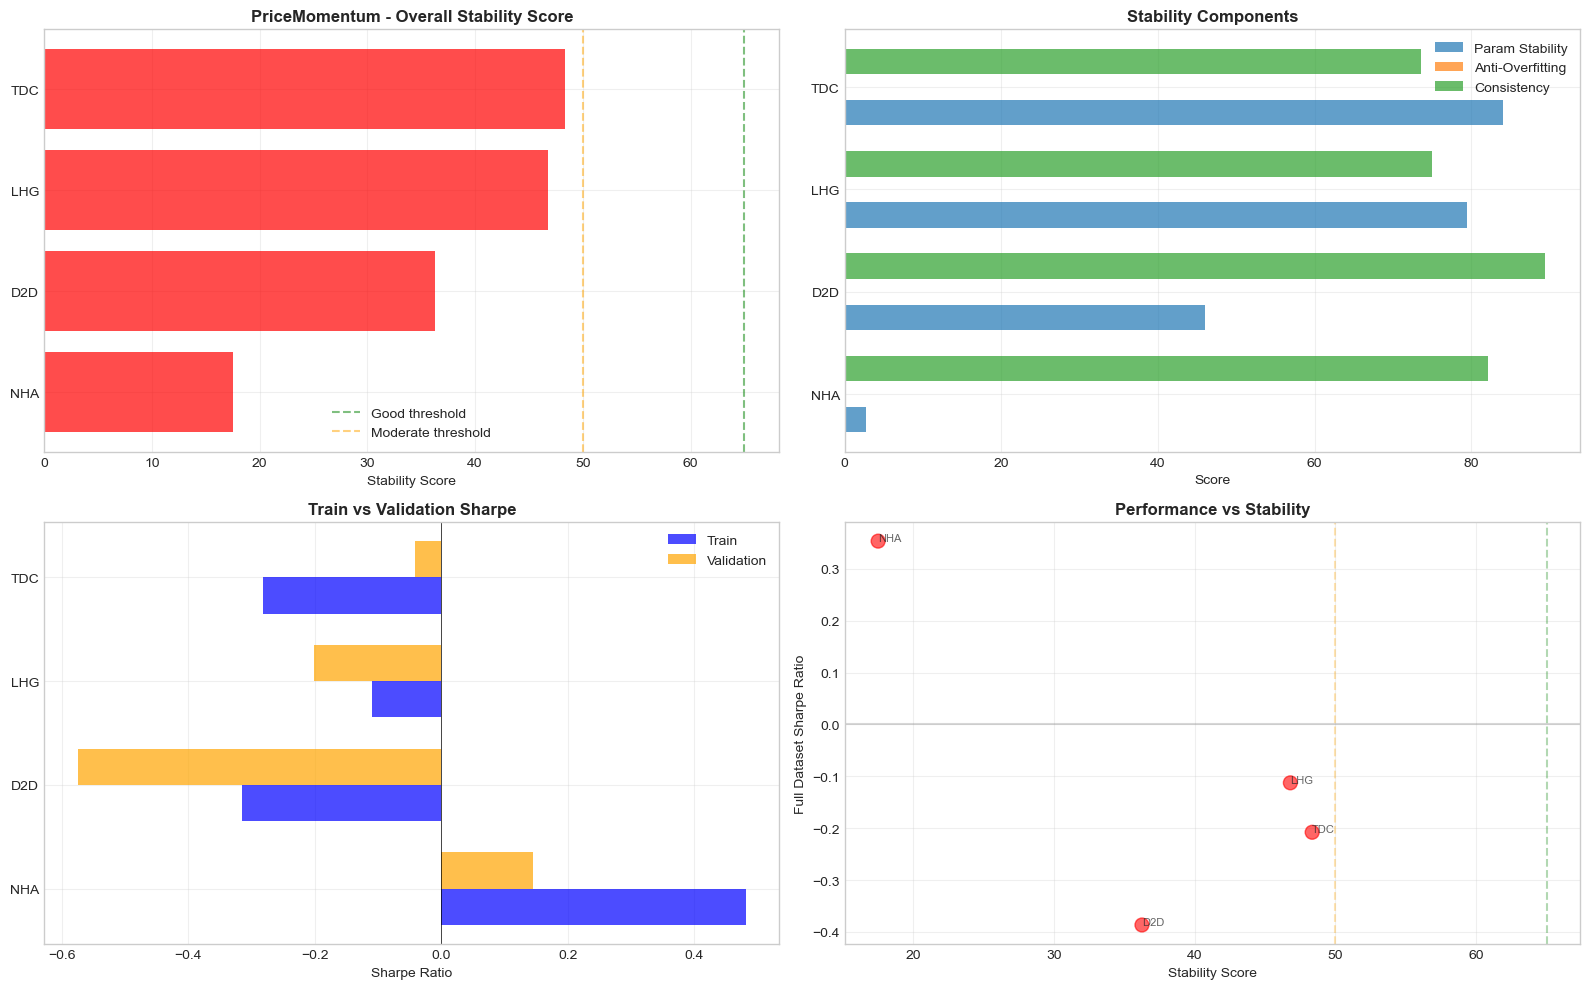

In [40]:
# Run sensitivity analysis for PriceMomentum
sensitivity_results_price = run_sensitivity_on_universe_results(
    all_symbols_data=all_symbols,
    universe_results=results_price,
    strategy_class=PriceMomentum,
    param_ranges_func=get_price_momentum_sensitivity_ranges,
    transaction_cost=0.001
)

# Create summary
summary_price = create_universe_summary(sensitivity_results_price, "PriceMomentum")
print("\n" + "="*80)
print("PRICEMOMENTUM - UNIVERSE SUMMARY (Sorted by Stability)")
print("="*80)
print(summary_price.to_string(index=False))

# Plot comparison
plot_universe_stability_comparison(summary_price, "PriceMomentum")


In [41]:
# ============================================================
# 2. OPTIMIZE MACDMOMENTUM ON UNIVERSE
# ============================================================

param_spaces_macd_univ = {
    'fast': ('int', 5, 50),
    'slow': ('int', 20, 200),
    'signal': ('int', 5, 50),
}

results_macd = optimize_strategy_on_universe(
    all_symbols_data=all_symbols,
    strategy_class=MACDMomentum,
    param_space=param_spaces_macd_univ,
    optimizer=optimizer,
    n_stocks=10,
    min_data_points=500,
    transaction_cost=0.001
)

print(f"\n✓ MACDMomentum optimization completed on {len(results_macd)} stocks")



OPTIMIZING MACDMomentum ON UNIVERSE
Valid symbols: 35
Testing on: 10 stocks
Symbols: DXS, CIC, NHA, LHG, VRE, DIG, ROS, D2D, PDR, TDC

[1/10] Optimizing DXS...

OPTIMIZATION START - Strategy: bayesian
Constraints: 1
Trials: 100
Direction: maximize

Optimization completed in 1.0s
Best Score: -inf
Best Params: {}
   ✗ No valid parameters found

[2/10] Optimizing CIC...

OPTIMIZATION START - Strategy: bayesian
Constraints: 1
Trials: 100
Direction: maximize

Optimization completed in 1.1s
Best Score: -inf
Best Params: {}
   ✗ No valid parameters found

[3/10] Optimizing NHA...

OPTIMIZATION START - Strategy: bayesian
Constraints: 1
Trials: 100
Direction: maximize

Optimization completed in 1.7s
Best Score: 0.788857
Best Params: {'fast': 9, 'slow': 186, 'signal': 7}
   ✓ Best params: {'fast': 9, 'slow': 186, 'signal': 7}
   ✓ Train Sharpe: -0.285
   ✓ Val Sharpe: 0.789
   ✓ Full Sharpe: -0.045

[4/10] Optimizing LHG...

OPTIMIZATION START - Strategy: bayesian
Constraints: 1
Trials: 100
Dir


SENSITIVITY ANALYSIS ON UNIVERSE RESULTS

[1/6] Analyzing NHA...
   ✓ Stability Score: 50.9/100
   ✓ Rating: MODERATE

[2/6] Analyzing LHG...
   ✓ Stability Score: 37.3/100
   ✓ Rating: POOR

[3/6] Analyzing DIG...
   ✓ Stability Score: 53.9/100
   ✓ Rating: MODERATE

[4/6] Analyzing D2D...
   ✓ Stability Score: 55.9/100
   ✓ Rating: MODERATE

[5/6] Analyzing PDR...
   ✓ Stability Score: 36.3/100
   ✓ Rating: POOR

[6/6] Analyzing TDC...
   ✓ Stability Score: 50.8/100
   ✓ Rating: MODERATE

MACDMOMENTUM - UNIVERSE SUMMARY (Sorted by Stability)
Symbol  Stability_Score Stability_Rating  Param_Sensitivity  Overfitting_Score  Consistency_Score  Full_Sharpe  Train_Sharpe  Val_Sharpe  Full_Return  Win_Rate  Max_Drawdown  Num_Trades
   D2D        55.855150         MODERATE          94.867033                  0          89.541684    -0.140567     -0.302398    0.553427    -0.486641  0.454060     -0.889422       127.5
   DIG        53.860094         MODERATE          97.117193                  

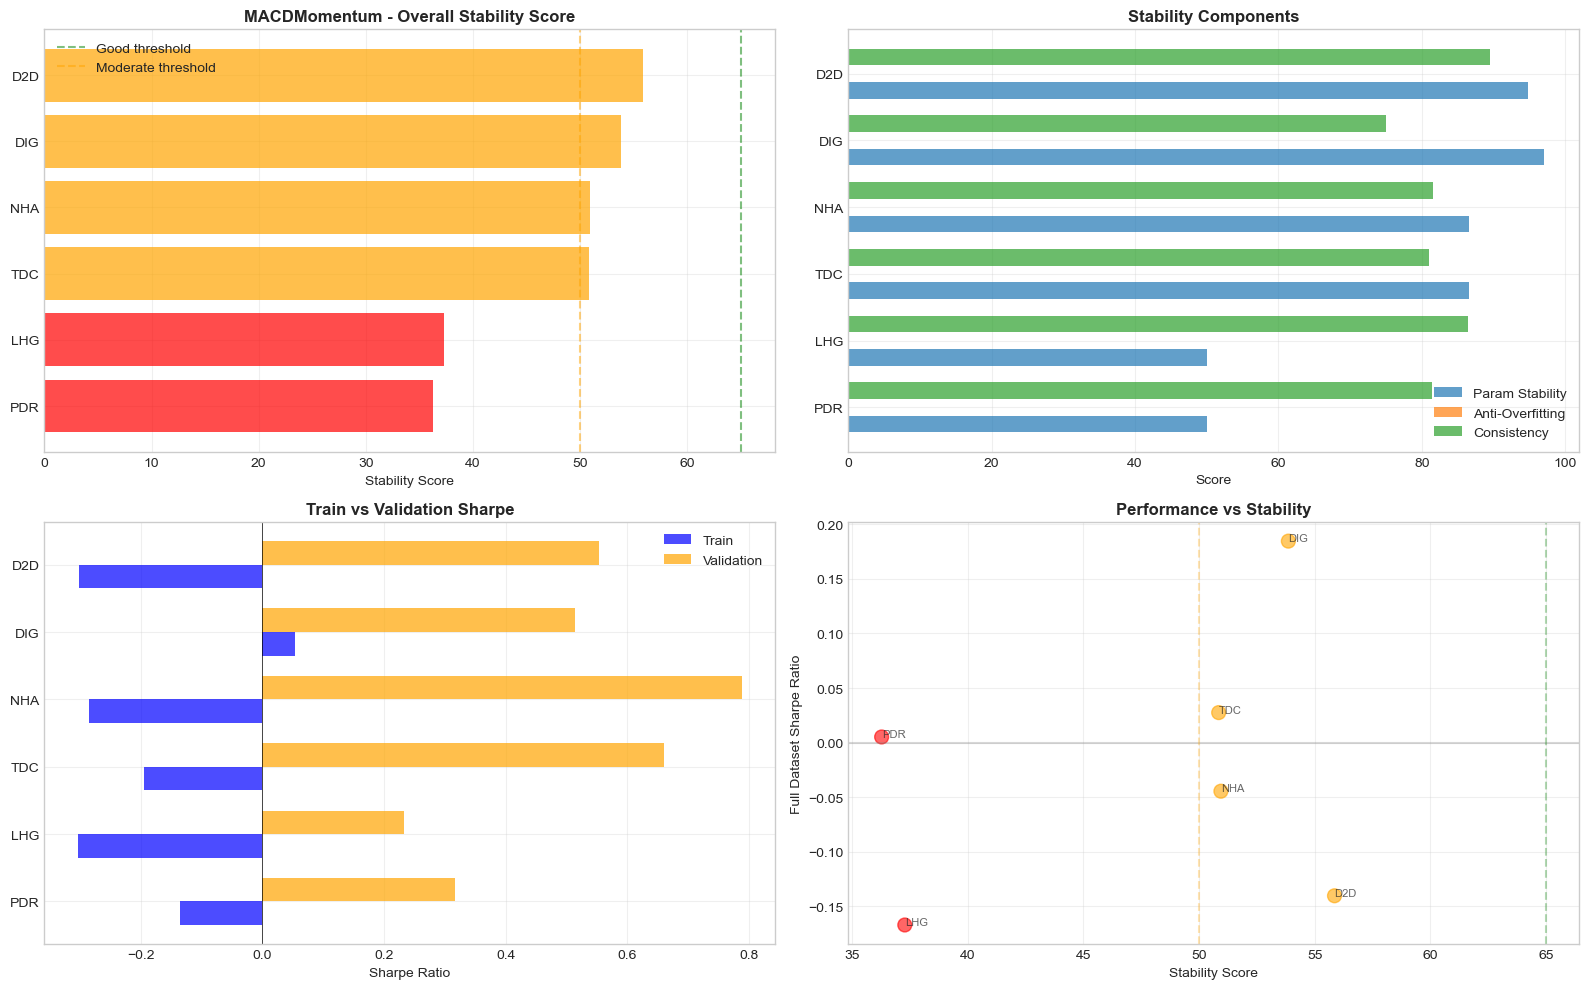

In [42]:
# Run sensitivity analysis for MACDMomentum
sensitivity_results_macd = run_sensitivity_on_universe_results(
    all_symbols_data=all_symbols,
    universe_results=results_macd,
    strategy_class=MACDMomentum,
    param_ranges_func=get_macd_momentum_sensitivity_ranges,
    transaction_cost=0.001
)

# Create summary
summary_macd = create_universe_summary(sensitivity_results_macd, "MACDMomentum")
print("\n" + "="*80)
print("MACDMOMENTUM - UNIVERSE SUMMARY (Sorted by Stability)")
print("="*80)
print(summary_macd.to_string(index=False))

# Plot comparison
plot_universe_stability_comparison(summary_macd, "MACDMomentum")


In [43]:
# ============================================================
# 3. OPTIMIZE RSIMOMENTUM ON UNIVERSE
# ============================================================

param_spaces_rsi_univ = {
    'period': ('int', 7, 21),
    'oversold': ('int', 20, 35),
    'overbought': ('int', 65, 80),
}

results_rsi = optimize_strategy_on_universe(
    all_symbols_data=all_symbols,
    strategy_class=RSIMomentum,
    param_space=param_spaces_rsi_univ,
    optimizer=optimizer,
    n_stocks=10,
    min_data_points=500,
    transaction_cost=0.001
)

print(f"\n✓ RSIMomentum optimization completed on {len(results_rsi)} stocks")



OPTIMIZING RSIMomentum ON UNIVERSE
Valid symbols: 35
Testing on: 10 stocks
Symbols: DXS, CIC, NHA, LHG, VRE, DIG, ROS, D2D, PDR, TDC

[1/10] Optimizing DXS...

OPTIMIZATION START - Strategy: bayesian
Constraints: 1
Trials: 100
Direction: maximize

Optimization completed in 3.1s
Best Score: -inf
Best Params: {}
   ✗ No valid parameters found

[2/10] Optimizing CIC...

OPTIMIZATION START - Strategy: bayesian
Constraints: 1
Trials: 100
Direction: maximize

Optimization completed in 3.9s
Best Score: -inf
Best Params: {}
   ✗ No valid parameters found

[3/10] Optimizing NHA...

OPTIMIZATION START - Strategy: bayesian
Constraints: 1
Trials: 100
Direction: maximize

Optimization completed in 9.0s
Best Score: 0.651715
Best Params: {'period': 19, 'oversold': 35, 'overbought': 65}
   ✓ Best params: {'period': 19, 'oversold': 35, 'overbought': 65}
   ✓ Train Sharpe: -0.666
   ✓ Val Sharpe: 0.652
   ✓ Full Sharpe: -0.380

[4/10] Optimizing LHG...

OPTIMIZATION START - Strategy: bayesian
Constrain


SENSITIVITY ANALYSIS ON UNIVERSE RESULTS

[1/7] Analyzing NHA...
   ✓ Stability Score: 35.4/100
   ✓ Rating: POOR

[2/7] Analyzing LHG...
   ✓ Stability Score: 30.9/100
   ✓ Rating: VERY POOR

[3/7] Analyzing VRE...
   ✓ Stability Score: 44.8/100
   ✓ Rating: POOR

[4/7] Analyzing DIG...
   ✓ Stability Score: 44.4/100
   ✓ Rating: POOR

[5/7] Analyzing D2D...
   ✓ Stability Score: 42.7/100
   ✓ Rating: POOR

[6/7] Analyzing PDR...
   ✓ Stability Score: 47.6/100
   ✓ Rating: POOR

[7/7] Analyzing TDC...
   ✓ Stability Score: 32.8/100
   ✓ Rating: VERY POOR

RSIMOMENTUM - UNIVERSE SUMMARY (Sorted by Stability)
Symbol  Stability_Score Stability_Rating  Param_Sensitivity  Overfitting_Score  Consistency_Score  Full_Sharpe  Train_Sharpe  Val_Sharpe  Full_Return  Win_Rate  Max_Drawdown  Num_Trades
   PDR        47.643612             POOR          83.528449                  0          71.161160     0.033821      0.074700   -0.052221     0.053212  0.229947     -0.268068       280.5
   VRE     

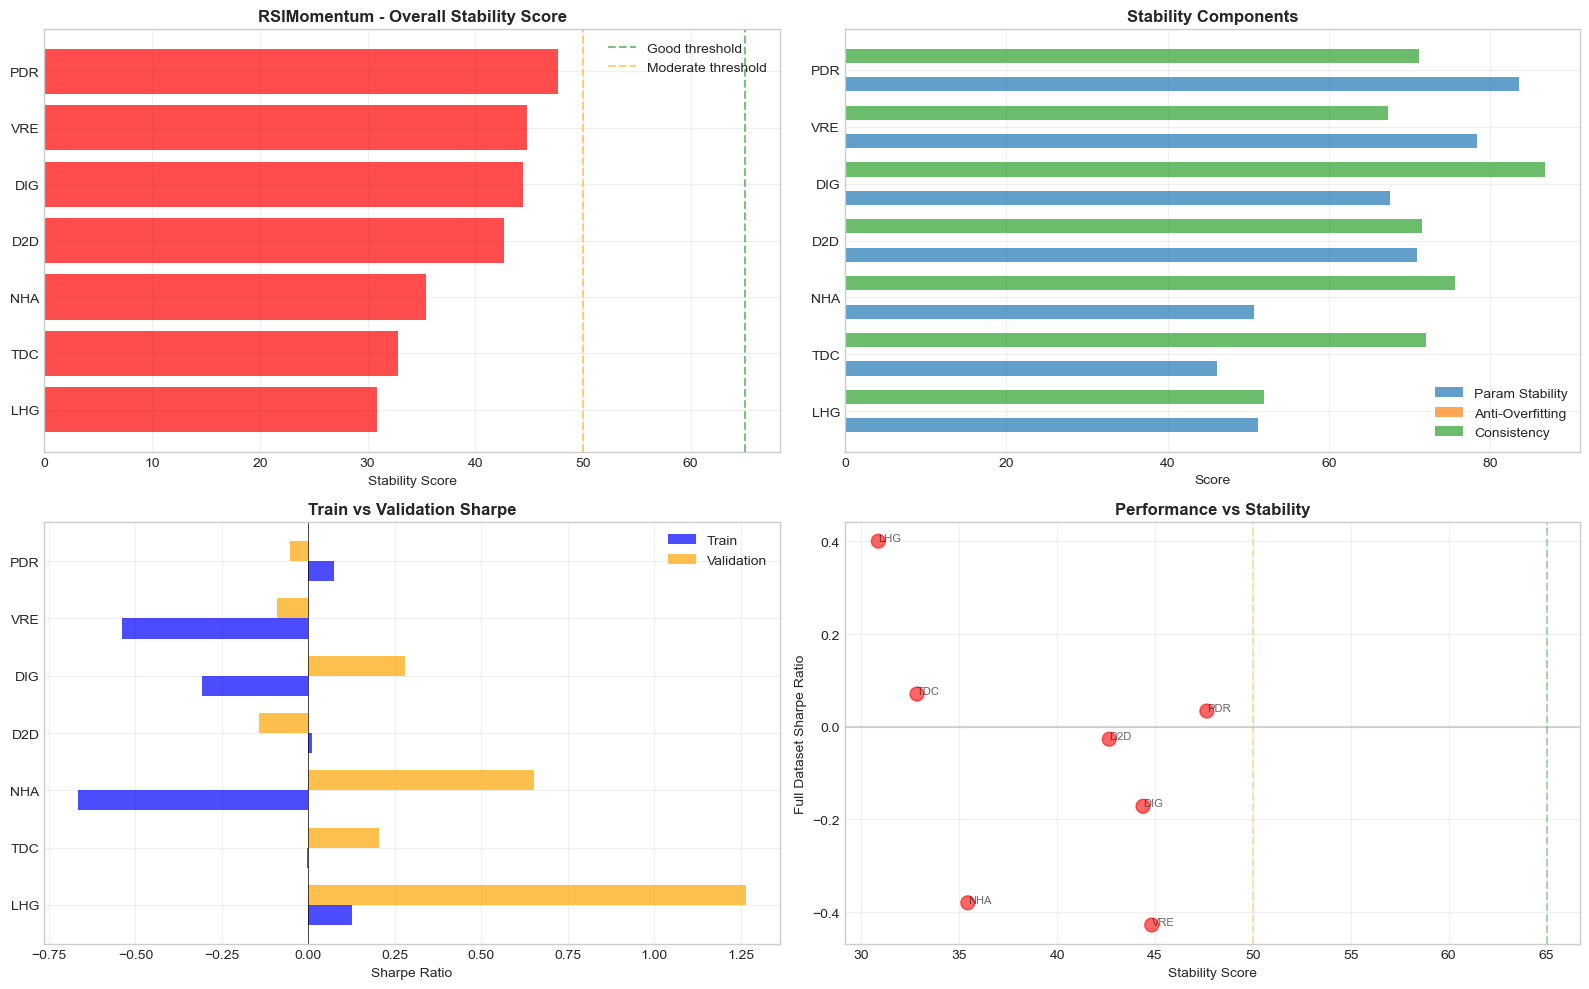

In [44]:
# Run sensitivity analysis for RSIMomentum
sensitivity_results_rsi_univ = run_sensitivity_on_universe_results(
    all_symbols_data=all_symbols,
    universe_results=results_rsi,
    strategy_class=RSIMomentum,
    param_ranges_func=get_rsi_momentum_sensitivity_ranges,
    transaction_cost=0.001
)

# Create summary
summary_rsi = create_universe_summary(sensitivity_results_rsi_univ, "RSIMomentum")
print("\n" + "="*80)
print("RSIMOMENTUM - UNIVERSE SUMMARY (Sorted by Stability)")
print("="*80)
print(summary_rsi.to_string(index=False))

# Plot comparison
plot_universe_stability_comparison(summary_rsi, "RSIMomentum")


## Compare all strategies across universe


CROSS-STRATEGY COMPARISON
     Strategy  Avg_Stability_Score  Min_Stability_Score  Max_Stability_Score  Excellent_Count  Good_Count  Moderate_Count  Poor_Count  Avg_Full_Sharpe  Avg_Return  Avg_Win_Rate  Avg_Max_Drawdown  Stocks_Tested
 MACDMomentum            47.510296            36.277166            55.855150                0           0               4           2        -0.022555    0.082959      0.445184         -0.855988              6
  RSIMomentum            39.805927            30.859465            47.643612                0           0               0           7        -0.071622   -0.044086      0.207736         -0.375004              7
PriceMomentum            37.232909            17.520320            48.349737                0           0               0           4        -0.088467    1.762081      0.430878         -0.761717              4


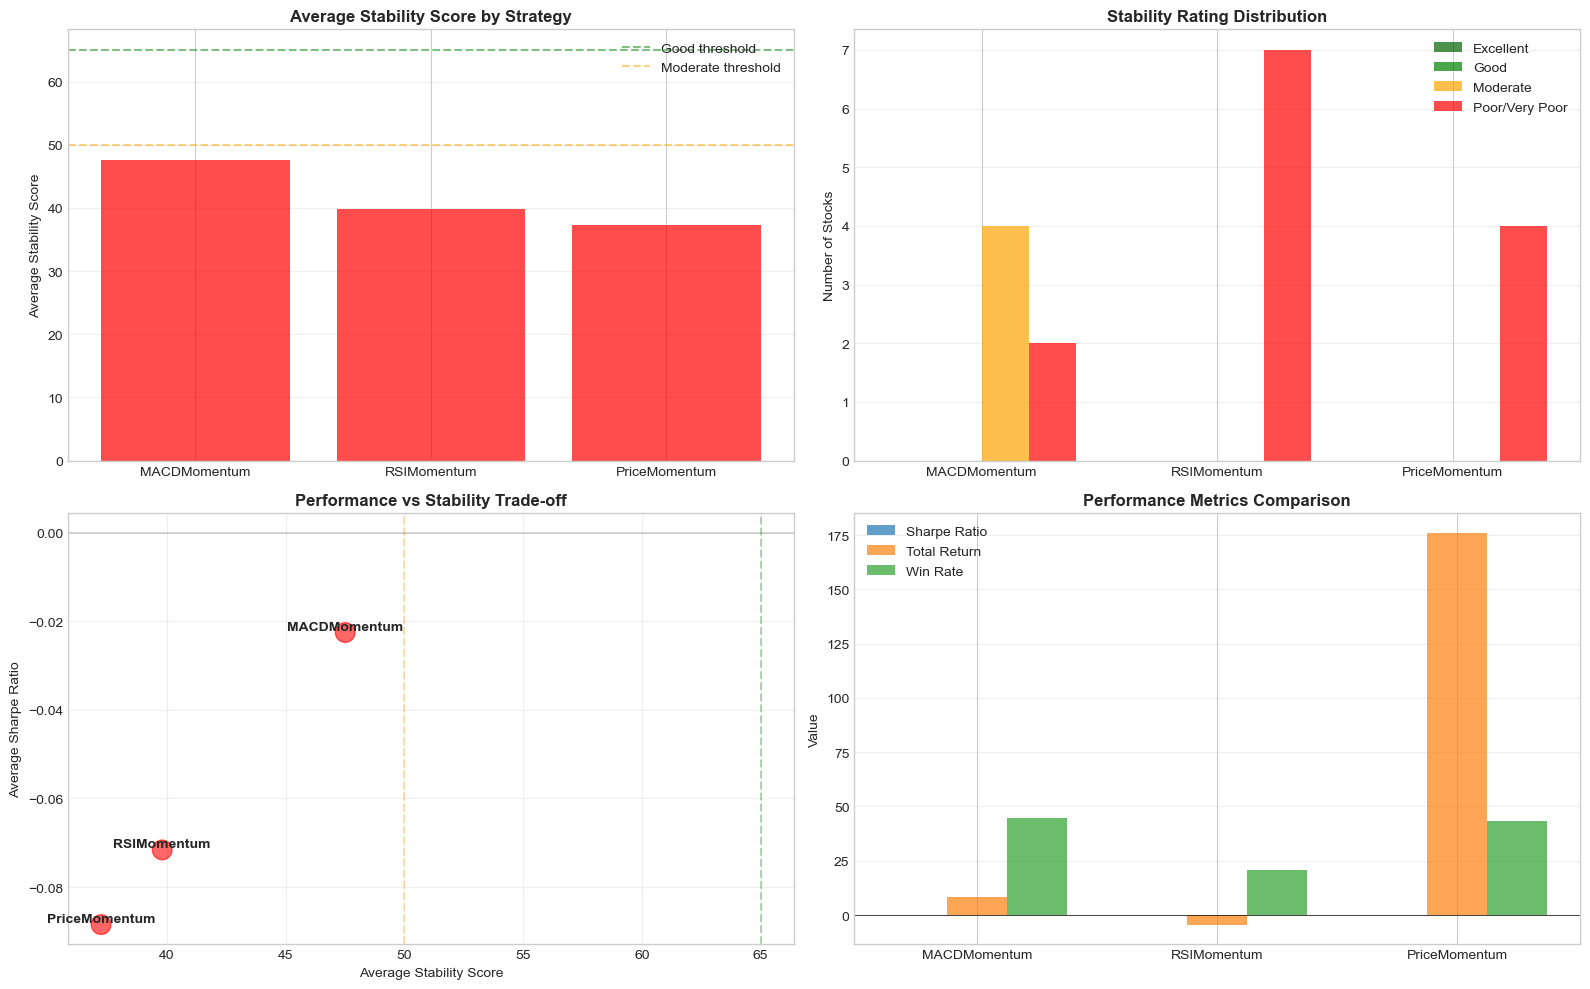

In [45]:
# ============================================================
# CROSS-STRATEGY COMPARISON
# ============================================================

def compare_all_strategies(summary_dfs, strategy_names):
    """
    Compare all strategies across the universe.
    
    Args:
        summary_dfs: List of summary dataframes
        strategy_names: List of strategy names
    
    Returns:
        Combined comparison dataframe
    """
    # Aggregate by strategy
    strategy_comparison = []
    
    for summary_df, strategy_name in zip(summary_dfs, strategy_names):
        strategy_comparison.append({
            'Strategy': strategy_name,
            'Avg_Stability_Score': summary_df['Stability_Score'].mean(),
            'Min_Stability_Score': summary_df['Stability_Score'].min(),
            'Max_Stability_Score': summary_df['Stability_Score'].max(),
            'Excellent_Count': (summary_df['Stability_Rating'] == 'EXCELLENT').sum(),
            'Good_Count': (summary_df['Stability_Rating'] == 'GOOD').sum(),
            'Moderate_Count': (summary_df['Stability_Rating'] == 'MODERATE').sum(),
            'Poor_Count': ((summary_df['Stability_Rating'] == 'POOR') | 
                          (summary_df['Stability_Rating'] == 'VERY POOR')).sum(),
            'Avg_Full_Sharpe': summary_df['Full_Sharpe'].mean(),
            'Avg_Return': summary_df['Full_Return'].mean(),
            'Avg_Win_Rate': summary_df['Win_Rate'].mean(),
            'Avg_Max_Drawdown': summary_df['Max_Drawdown'].mean(),
            'Stocks_Tested': len(summary_df)
        })
    
    comparison_df = pd.DataFrame(strategy_comparison)
    comparison_df = comparison_df.sort_values('Avg_Stability_Score', ascending=False)
    
    return comparison_df


def plot_cross_strategy_comparison(comparison_df):
    """Plot cross-strategy comparison."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    strategies = comparison_df['Strategy'].tolist()
    
    # 1. Average Stability Score
    colors = ['green' if x >= 65 else 'orange' if x >= 50 else 'red' 
              for x in comparison_df['Avg_Stability_Score']]
    axes[0, 0].bar(strategies, comparison_df['Avg_Stability_Score'], 
                   color=colors, alpha=0.7)
    axes[0, 0].axhline(y=65, color='green', linestyle='--', alpha=0.5, label='Good threshold')
    axes[0, 0].axhline(y=50, color='orange', linestyle='--', alpha=0.5, label='Moderate threshold')
    axes[0, 0].set_ylabel('Average Stability Score')
    axes[0, 0].set_title('Average Stability Score by Strategy', fontsize=12, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # 2. Stability Rating Distribution
    x = np.arange(len(strategies))
    width = 0.2
    
    axes[0, 1].bar(x - 1.5*width, comparison_df['Excellent_Count'], width, 
                   label='Excellent', alpha=0.7, color='darkgreen')
    axes[0, 1].bar(x - 0.5*width, comparison_df['Good_Count'], width, 
                   label='Good', alpha=0.7, color='green')
    axes[0, 1].bar(x + 0.5*width, comparison_df['Moderate_Count'], width, 
                   label='Moderate', alpha=0.7, color='orange')
    axes[0, 1].bar(x + 1.5*width, comparison_df['Poor_Count'], width, 
                   label='Poor/Very Poor', alpha=0.7, color='red')
    
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(strategies)
    axes[0, 1].set_ylabel('Number of Stocks')
    axes[0, 1].set_title('Stability Rating Distribution', fontsize=12, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # 3. Performance vs Stability
    axes[1, 0].scatter(comparison_df['Avg_Stability_Score'], 
                      comparison_df['Avg_Full_Sharpe'],
                      s=200, alpha=0.6, c=colors)
    
    for idx, row in comparison_df.iterrows():
        axes[1, 0].annotate(row['Strategy'], 
                           (row['Avg_Stability_Score'], row['Avg_Full_Sharpe']),
                           fontsize=10, fontweight='bold',
                           ha='center', va='bottom')
    
    axes[1, 0].set_xlabel('Average Stability Score')
    axes[1, 0].set_ylabel('Average Sharpe Ratio')
    axes[1, 0].set_title('Performance vs Stability Trade-off', fontsize=12, fontweight='bold')
    axes[1, 0].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    axes[1, 0].axvline(x=50, color='orange', linestyle='--', alpha=0.3)
    axes[1, 0].axvline(x=65, color='green', linestyle='--', alpha=0.3)
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Key Metrics Comparison
    metrics_to_plot = ['Avg_Full_Sharpe', 'Avg_Return', 'Avg_Win_Rate']
    metrics_labels = ['Sharpe Ratio', 'Total Return', 'Win Rate']
    
    x = np.arange(len(strategies))
    width = 0.25
    
    for i, (metric, label) in enumerate(zip(metrics_to_plot, metrics_labels)):
        values = comparison_df[metric].tolist()
        if metric == 'Avg_Return' or metric == 'Avg_Win_Rate':
            values = [v * 100 for v in values]  # Convert to percentage
        axes[1, 1].bar(x + (i - 1) * width, values, width, label=label, alpha=0.7)
    
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(strategies)
    axes[1, 1].set_ylabel('Value')
    axes[1, 1].set_title('Performance Metrics Comparison', fontsize=12, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    axes[1, 1].axhline(y=0, color='black', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()


# Compare all three strategies
summary_dfs = [summary_price, summary_macd, summary_rsi]
strategy_names = ['PriceMomentum', 'MACDMomentum', 'RSIMomentum']

cross_strategy_comparison = compare_all_strategies(summary_dfs, strategy_names)

print("\n" + "="*80)
print("CROSS-STRATEGY COMPARISON")
print("="*80)
print(cross_strategy_comparison.to_string(index=False))

plot_cross_strategy_comparison(cross_strategy_comparison)


## Get best stable stocks for each strategy

In [47]:
# ============================================================
# IDENTIFY BEST STABLE STOCKS
# ============================================================

def get_best_stable_stocks(summary_df, strategy_name, 
                          min_stability_score=65, 
                          min_sharpe=0.5,
                          top_n=5):
    """
    Get the best stable stocks for a strategy.
    
    Args:
        summary_df: Summary dataframe
        strategy_name: Name of strategy
        min_stability_score: Minimum stability score threshold
        min_sharpe: Minimum Sharpe ratio threshold
        top_n: Number of top stocks to return
    
    Returns:
        Dataframe of best stable stocks
    """
    # Filter by criteria
    filtered = summary_df[
        (summary_df['Stability_Score'] >= min_stability_score) &
        (summary_df['Full_Sharpe'] >= min_sharpe)
    ].copy()
    
    # Create combined score (stability + performance)
    # Normalize both to 0-1 scale
    if len(filtered) > 0:
        filtered['Normalized_Stability'] = filtered['Stability_Score'] / 100
        max_sharpe = filtered['Full_Sharpe'].max()
        if max_sharpe > 0:
            filtered['Normalized_Sharpe'] = filtered['Full_Sharpe'] / max_sharpe
        else:
            filtered['Normalized_Sharpe'] = 0
        
        # Combined score: 60% stability, 40% performance
        filtered['Combined_Score'] = (
            filtered['Normalized_Stability'] * 0.6 + 
            filtered['Normalized_Sharpe'] * 0.4
        )
        
        # Sort by combined score
        filtered = filtered.sort_values('Combined_Score', ascending=False)
        
        return filtered.head(top_n)
    else:
        return pd.DataFrame()


print("\n" + "="*80)
print("BEST STABLE STOCKS - PRICEMOMENTUM")
print("="*80)
best_stable_price = get_best_stable_stocks(summary_price, 'PriceMomentum', 
                                           min_stability_score=60, 
                                           min_sharpe=0.3, 
                                           top_n=5)
if len(best_stable_price) > 0:
    print(best_stable_price[['Symbol', 'Stability_Score', 'Stability_Rating', 
                            'Full_Sharpe', 'Full_Return', 'Win_Rate', 
                            'Combined_Score']].to_string(index=False))
else:
    print("No stocks meet the criteria")

print("\n" + "="*80)
print("BEST STABLE STOCKS - MACDMOMENTUM")
print("="*80)
best_stable_macd = get_best_stable_stocks(summary_macd, 'MACDMomentum', 
                                         min_stability_score=60, 
                                         min_sharpe=0.3, 
                                         top_n=5)
if len(best_stable_macd) > 0:
    print(best_stable_macd[['Symbol', 'Stability_Score', 'Stability_Rating', 
                           'Full_Sharpe', 'Full_Return', 'Win_Rate', 
                           'Combined_Score']].to_string(index=False))
else:
    print("No stocks meet the criteria")

print("\n" + "="*80)
print("BEST STABLE STOCKS - RSIMOMENTUM")
print("="*80)
best_stable_rsi = get_best_stable_stocks(summary_rsi, 'RSIMomentum', 
                                        min_stability_score=60, 
                                        min_sharpe=0.3, 
                                        top_n=5)
if len(best_stable_rsi) > 0:
    print(best_stable_rsi[['Symbol', 'Stability_Score', 'Stability_Rating', 
                          'Full_Sharpe', 'Full_Return', 'Win_Rate', 
                          'Combined_Score']].to_string(index=False))
else:
    print("No stocks meet the criteria")



BEST STABLE STOCKS - PRICEMOMENTUM
No stocks meet the criteria

BEST STABLE STOCKS - MACDMOMENTUM
No stocks meet the criteria

BEST STABLE STOCKS - RSIMOMENTUM
No stocks meet the criteria


## Detailed stability report for top stocks

In [48]:
# Print detailed stability reports for top stocks of each strategy

# PriceMomentum - Top stock
if len(best_stable_price) > 0:
    top_symbol = best_stable_price.iloc[0]['Symbol']
    print(f"\n{'='*80}")
    print(f"DETAILED REPORT - PRICEMOMENTUM on {top_symbol} (Best Stable)")
    print(f"{'='*80}")
    
    stability_metrics = sensitivity_results_price[top_symbol]['stability_metrics']
    print_stability_report(stability_metrics, f"PriceMomentum - {top_symbol}")
    
    best_params = sensitivity_results_price[top_symbol]['best_params']
    sensitivity = sensitivity_results_price[top_symbol]['sensitivity']
    
    print("\n📋 Best Parameters:")
    for param, value in best_params.items():
        print(f"   - {param}: {value}")
    
    # Plot sensitivity
    plot_sensitivity(sensitivity, best_params, f"PriceMomentum - {top_symbol}")

# MACDMomentum - Top stock
if len(best_stable_macd) > 0:
    top_symbol = best_stable_macd.iloc[0]['Symbol']
    print(f"\n{'='*80}")
    print(f"DETAILED REPORT - MACDMOMENTUM on {top_symbol} (Best Stable)")
    print(f"{'='*80}")
    
    stability_metrics = sensitivity_results_macd[top_symbol]['stability_metrics']
    print_stability_report(stability_metrics, f"MACDMomentum - {top_symbol}")
    
    best_params = sensitivity_results_macd[top_symbol]['best_params']
    sensitivity = sensitivity_results_macd[top_symbol]['sensitivity']
    
    print("\n📋 Best Parameters:")
    for param, value in best_params.items():
        print(f"   - {param}: {value}")
    
    # Plot sensitivity
    plot_sensitivity(sensitivity, best_params, f"MACDMomentum - {top_symbol}")

# RSIMomentum - Top stock
if len(best_stable_rsi) > 0:
    top_symbol = best_stable_rsi.iloc[0]['Symbol']
    print(f"\n{'='*80}")
    print(f"DETAILED REPORT - RSIMOMENTUM on {top_symbol} (Best Stable)")
    print(f"{'='*80}")
    
    stability_metrics = sensitivity_results_rsi_univ[top_symbol]['stability_metrics']
    print_stability_report(stability_metrics, f"RSIMomentum - {top_symbol}")
    
    best_params = sensitivity_results_rsi_univ[top_symbol]['best_params']
    sensitivity = sensitivity_results_rsi_univ[top_symbol]['sensitivity']
    
    print("\n📋 Best Parameters:")
    for param, value in best_params.items():
        print(f"   - {param}: {value}")
    
    # Plot sensitivity
    plot_sensitivity(sensitivity, best_params, f"RSIMomentum - {top_symbol}")
